In [2]:
# change to the root directory of the project
import os
if os.getcwd().split("/")[-1] == "examples":
    os.chdir('..')
print(os.getcwd())

import numpy as np
import pandas as pd
import random
from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.collections import PolyCollection
from matplotlib import colors
cl = list(colors.TABLEAU_COLORS.values())
from matplotlib.colors import to_rgb

# Import the PxlDDModel model
# from source.models.pxlDDM import PxlDDModel
# from source.models.objDDM import ObjDDModel
# from source.data.dataclass import Dataset
# import source.utils.functions as uf

from neurolib.utils.parameterSpace import ParameterSpace
from neurolib.optimize.evolution import Evolution

/home/nico/project_code/ScanDy


In [2]:
vidlist = sorted(['dance01', 'dance02', 'field03', 'foutain02', 'garden04', 'garden06', 'garden07', 'garden09', 'park01', 'park06', 'park09', 'road02', 'road04', 'road05', 'robarm01', 'room01', 'room02', 'room03', 'tommy02', 'uscdog01', 'walkway01', 'walkway02', 'walkway03'])
random.seed(12345)
trainlist = sorted(random.sample(vidlist, 10))
testlist = sorted([vidname for vidname in vidlist if vidname not in trainlist])
print("trainlist = ", trainlist, "\ntestlist =", testlist)

datadict = {
    # 'PATH' : '/mnt/raid/data/SCIoI/USCiLab/VidCom/',
    "PATH": "/scratch/nroth/VidCom/VidCom/", # HPC
    'FPS' : 30,
    'PX_TO_DVA' : 0.06,
    'FRAMES_ALL_VIDS' : 300,
    'gt_foveation_df' : '2021-12-04_VidCom_GT_fov_df',
    'gt_fovframes_nss_df' : 'gt_fovframes_nss_df.csv',
    'trainset' : trainlist,
    'testset' : testlist,
}
VidCom = Dataset(datadict)

trainlist =  ['dance01', 'dance02', 'garden06', 'garden07', 'park01', 'park06', 'road02', 'road05', 'room01', 'walkway03'] 
testlist = ['field03', 'foutain02', 'garden04', 'garden09', 'park09', 'road04', 'robarm01', 'room02', 'room03', 'tommy02', 'uscdog01', 'walkway01', 'walkway02']


Get the ground truth human data

In [3]:
gt_amp_dva = VidCom.gt_foveation_df["sac_amp_dva"].dropna().values
gt_dur_ms = VidCom.gt_foveation_df["duration_ms"].dropna().values

gt_amp_dva_train = VidCom.train_foveation_df["sac_amp_dva"].dropna().values
gt_dur_ms_train = VidCom.train_foveation_df["duration_ms"].dropna().values

gt_amp_dva_test = VidCom.test_foveation_df["sac_amp_dva"].dropna().values
gt_dur_ms_test = VidCom.test_foveation_df["duration_ms"].dropna().values

Fit distributions to the histograms and scale them appropriately

In [4]:
ampfit = stats.expon.fit(gt_amp_dva)
ampX = np.linspace(0,50, 200)
ampPDF = stats.expon.pdf(ampX, *ampfit)

durfit = stats.norm.fit(np.log10(gt_dur_ms))
durX = np.linspace(1,4, 200)
durPDF = stats.norm.pdf(durX, *durfit)
print(durfit, ampfit)

c_count, b_count = np.histogram(np.log10(gt_dur_ms), density=False,bins=40)
c_dense, b_dense = np.histogram(np.log10(gt_dur_ms), density=True,bins=40)
FD_fac = c_count.max()/c_dense.max()
c_count, b_count = np.histogram(gt_amp_dva, density=False,bins=60)
c_dense, b_dense = np.histogram(gt_amp_dva, density=True,bins=60)
SA_fac = c_count.max()/c_dense.max()

(2.490587926154523, 0.363944013720007) (0.06, 9.226529970987196)


In [5]:
10**(2.490587926154523+0.5*0.363944013720007**2)

360.4255324600343

In [6]:
10**0.363944013720007

2.3117667537764595

In [7]:
np.mean(gt_amp_dva)

9.286529970987196

In [8]:
stats.norm.fit(np.log(gt_dur_ms))

(5.734790631554358, 0.8380120606761086)

In [9]:
np.exp(5.734790631554358 + 0.5 * 0.8380120606761086**2)

439.6252847362015

## Fig 3 
### a & b

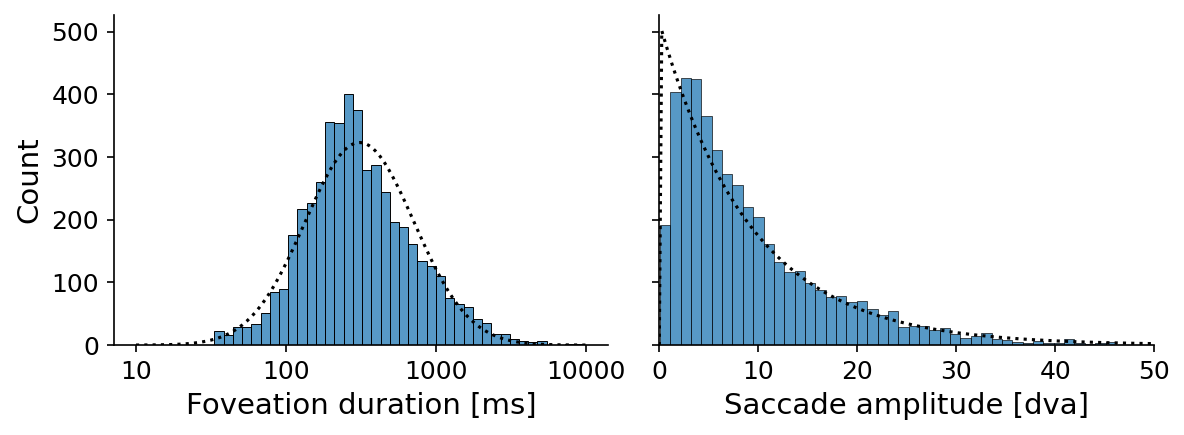

In [10]:
#fig, axs = plt.subplots(2,1,dpi=150, figsize=(5,6))
fig, axs = plt.subplots(1,2,dpi=150, figsize=(8,3), sharey=True)
sns.histplot(data=np.log10(gt_dur_ms), kde=False, ax=axs[0], bins=40)
axs[0].plot(durX, durPDF*FD_fac, color='k', ls=':')
axs[0].set_xticks([1,2,3,4])
axs[0].set_xticklabels([10,100,1000,10000])
axs[0].set_xlabel('Foveation duration [ms]', size=14)
axs[0].set_ylabel('Count', size=14)
sns.histplot(data=gt_amp_dva, kde=False, ax=axs[1], bins=60)
axs[1].set_xlabel('Saccade amplitude [dva]', size=14)
axs[1].set_xlim([0, 50])
axs[1].plot(ampX, ampPDF*SA_fac, color='k', ls=':', label='Fit')
axs[0].tick_params(labelsize=12)
axs[1].tick_params(labelsize=12)

# fig.suptitle('Human data scanpath statistics (VidCom dataset)', size=18) #   
#plt.legend()
sns.despine()
plt.tight_layout(); plt.show()

### c & d
in contrast to previously, where this was for all, now show training in transparent and test in opaque

training
testing


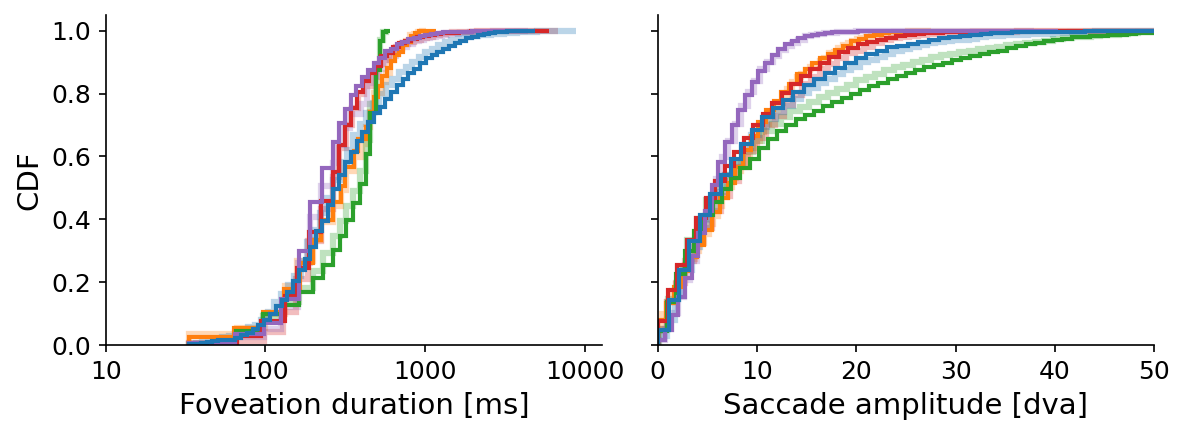

In [11]:
names = [
    'Location-based,\nlow-level features',
    'Location-based,\nhigh-level features',
    'Object-based,\nlow-level features',
    'Object-based,\ncenter bias only',
]

run_ids = [
    'pxDDM_train_molin_64-32-50_2022-12-14-02H-35M-35S_22026683',
    'pxDDM_train_TASEDnet_64-32-50_2022-12-14-02H-34M-38S_22026682',
    'objDDM_train_molin_64-32-50_2022-12-14-02H-36M-30S_22026684',
    'objDDM_train_None_64-32-50_2022-12-14-02H-37M-32S_22026685',
]

fig, axs = plt.subplots(1,2,dpi=150, figsize=(8,3), sharey=True)
for modus in ["training", "testing"]:
    c_idx = 0
    print(modus)

    if modus == "training":
        videoset = VidCom.trainset
        gt_amp_dva = VidCom.train_foveation_df["sac_amp_dva"].dropna().values
        gt_dur_ms = VidCom.train_foveation_df["duration_ms"].dropna().values
        gtname = 'Human data (train)'
        kwargs = {"lw":3, "alpha":0.3} #"ls":"dotted", 
    else:
        videoset = VidCom.testset
        gt_amp_dva = VidCom.test_foveation_df["sac_amp_dva"].dropna().values
        gt_dur_ms = VidCom.test_foveation_df["duration_ms"].dropna().values
        kwargs = {"lw":2}#, "ls":"dotted", "alpha":0.5}

    
    gtname = 'Human data'# (test)'


    df_res_pxMolin_top0 = pd.read_csv(f'./results/{run_ids[0]}/res_df_top0.csv')
    df_res_pxMolin_top0 = df_res_pxMolin_top0[df_res_pxMolin_top0['video'].isin(videoset)]
    px_llf_dur_ms = df_res_pxMolin_top0["duration_ms"].dropna().values
    px_llf_amp_dva = df_res_pxMolin_top0["sac_amp_dva"].dropna().values

    df_res_pxTased_top0 = pd.read_csv(f'./results/{run_ids[1]}/res_df_top0.csv')
    df_res_pxTased_top0 = df_res_pxTased_top0[df_res_pxTased_top0['video'].isin(videoset)]
    px_hlf_dur_ms = df_res_pxTased_top0["duration_ms"].dropna().values 
    px_hlf_amp_dva = df_res_pxTased_top0["sac_amp_dva"].dropna().values 

    df_res_objMolin_top0 = pd.read_csv(f'./results/{run_ids[2]}/res_df_top0.csv')
    df_res_objMolin_top0 = df_res_objMolin_top0[df_res_objMolin_top0['video'].isin(videoset)]
    obj_llf_dur_ms = df_res_objMolin_top0["duration_ms"].dropna().values
    obj_llf_amp_dva = df_res_objMolin_top0["sac_amp_dva"].dropna().values

    df_res_objNone_top0 = pd.read_csv(f'./results/{run_ids[3]}/res_df_top0.csv')
    df_res_objNone_top0 = df_res_objNone_top0[df_res_objNone_top0['video'].isin(videoset)]
    obj_cb_dur_ms = df_res_objNone_top0["duration_ms"].dropna().values
    obj_cb_amp_dva = df_res_objNone_top0["sac_amp_dva"].dropna().values

    nbins = 60
    # sns.histplot(data=np.log10(gt_dur_ms), kde=False, ax=axs[0], cumulative=True, element='step')#, bins=20)
    axs[0].hist(np.log10(px_llf_dur_ms), nbins, density=True, histtype='step', cumulative=True, label=names[0], color=cl[1], **kwargs)
    axs[0].hist(np.log10(px_hlf_dur_ms), nbins, density=True, histtype='step', cumulative=True, label=names[1], color=cl[2], **kwargs)
    axs[0].hist(np.log10(obj_llf_dur_ms), nbins, density=True, histtype='step', cumulative=True, label=names[2], color=cl[3], **kwargs)
    axs[0].hist(np.log10(obj_cb_dur_ms), nbins, density=True, histtype='step', cumulative=True, label=names[3], color=cl[4], **kwargs)
    axs[0].hist(np.log10(gt_dur_ms), nbins, density=True, histtype='step', cumulative=True, label=gtname, color=cl[0], **kwargs)
    axs[0].set_xticks([1,2,3,4])
    axs[0].set_xticklabels([10,100,1000,10000], size=14)
    axs[0].tick_params(labelsize=12)
    axs[0].set_xlabel('Foveation duration [ms]', size=14)
    axs[0].set_ylabel('CDF', size=14)
    #plt.legend()
    axs[1].hist(px_llf_amp_dva, nbins, density=True, histtype='step', cumulative=True, label=names[0], color=cl[1], **kwargs)
    axs[1].hist(px_hlf_amp_dva, nbins, density=True, histtype='step', cumulative=True, label=names[1], color=cl[2], **kwargs)
    axs[1].hist(obj_llf_amp_dva, nbins, density=True, histtype='step', cumulative=True, label=names[2], color=cl[3], **kwargs)
    axs[1].hist(obj_cb_amp_dva, nbins, density=True, histtype='step', cumulative=True, label=names[3], color=cl[4], **kwargs)
    axs[1].hist(gt_amp_dva, nbins, density=True, histtype='step', cumulative=True, label=gtname, color=cl[0], **kwargs)
    axs[1].set_xlabel('Saccade amplitude [dva]', size=14)
    axs[1].tick_params(labelsize=12)
    axs[1].set_xlim([0, 50])
    #fig.suptitle('Ground truth scanpath statistics (VidCom dataset)', size=18) #   
    #axs[1].legend(loc='lower right')
    uf.fix_hist_step_vertical_line_at_end(axs[0])
    uf.fix_hist_step_vertical_line_at_end(axs[1])
sns.despine(); plt.tight_layout(); plt.show()


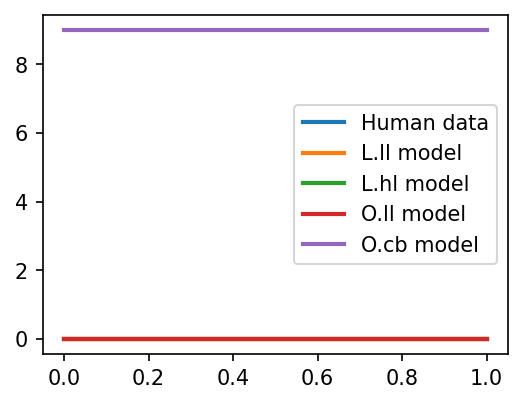

In [12]:
fig, ax = plt.subplots(1,1,dpi=150, figsize=(4,3))
ax.plot([0,1], [0,0], lw=2, label=gtname)
ax.plot([0,1], [0,0], lw=2, label="L.ll model")#names[0])
ax.plot([0,1], [0,0], lw=2, label="L.hl model")#names[1])
ax.plot([0,1], [0,0], lw=2, label="O.ll model")#names[2])
ax.plot([0,1], [9,9], lw=2, label="O.cb model")#names[3])
plt.legend()
plt.show()

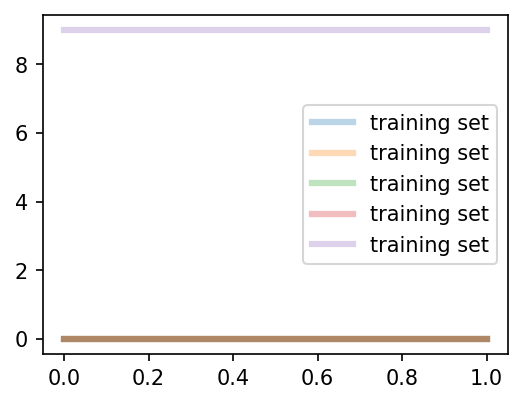

In [13]:
fig, ax = plt.subplots(1,1,dpi=150, figsize=(4,3))
ax.plot([0,1], [0,0], lw=3, alpha=0.3, label="training set")
ax.plot([0,1], [0,0], lw=3, alpha=0.3, label="training set")#names[0])
ax.plot([0,1], [0,0], lw=3, alpha=0.3, label="training set")#names[1])
ax.plot([0,1], [0,0], lw=3, alpha=0.3, label="training set")#names[2])
ax.plot([0,1], [9,9], lw=3, alpha=0.3, label="training set")#names[3])
plt.legend()
plt.show()

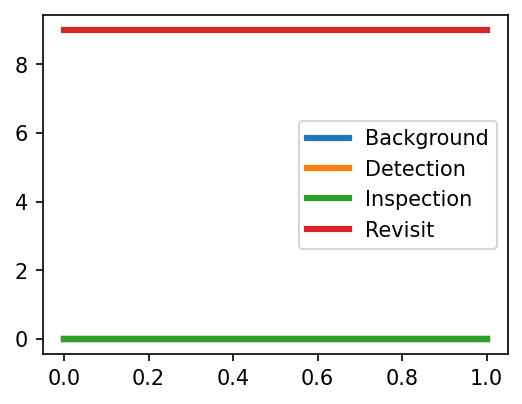

In [14]:
fig, ax = plt.subplots(1,1,dpi=150, figsize=(4,3))
ax.plot([0,1], [0,0], lw=3, label="Background")#names[0])
ax.plot([0,1], [0,0], lw=3, label="Detection")#names[1])
ax.plot([0,1], [0,0], lw=3, label="Inspection")#names[2])
ax.plot([0,1], [9,9], lw=3, label="Revisit")#names[3])
plt.legend()
plt.show()

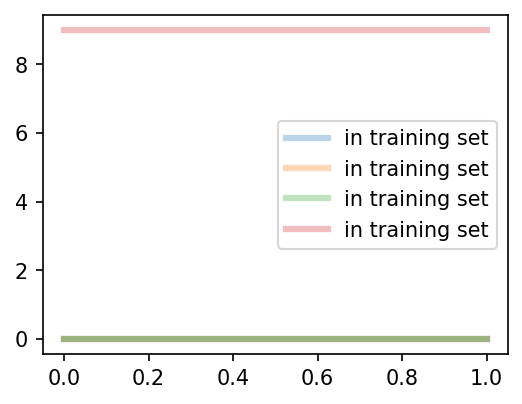

In [15]:
fig, ax = plt.subplots(1,1,dpi=150, figsize=(4,3))
ax.plot([0,1], [0,0], alpha=0.3, lw=3, label="in training set")#names[0])
ax.plot([0,1], [0,0], alpha=0.3, lw=3, label="in training set")#names[1])
ax.plot([0,1], [0,0], alpha=0.3, lw=3, label="in training set")#names[2])
ax.plot([0,1], [9,9], alpha=0.3, lw=3, label="in training set")#names[3])
plt.legend()
plt.show()

...add a custom legend with inkscape (cut from above and replace rectangles with lines)

## Fig 4 
### a) only human data

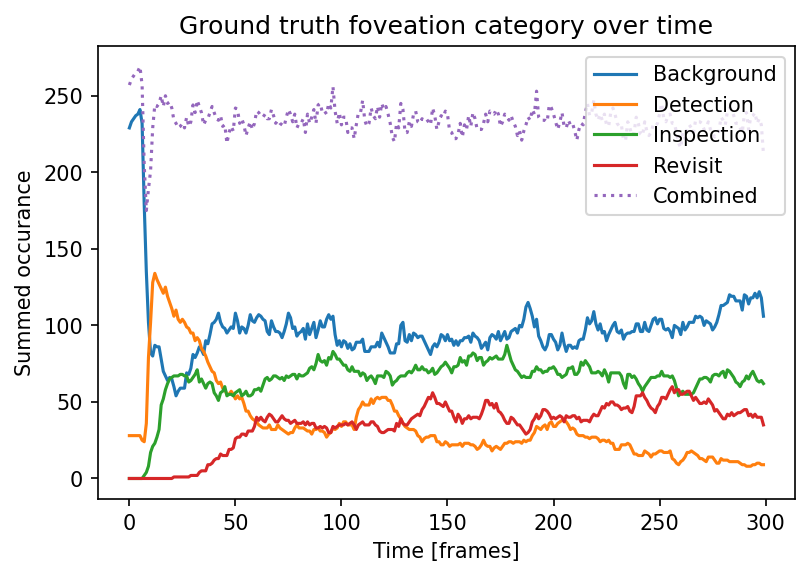

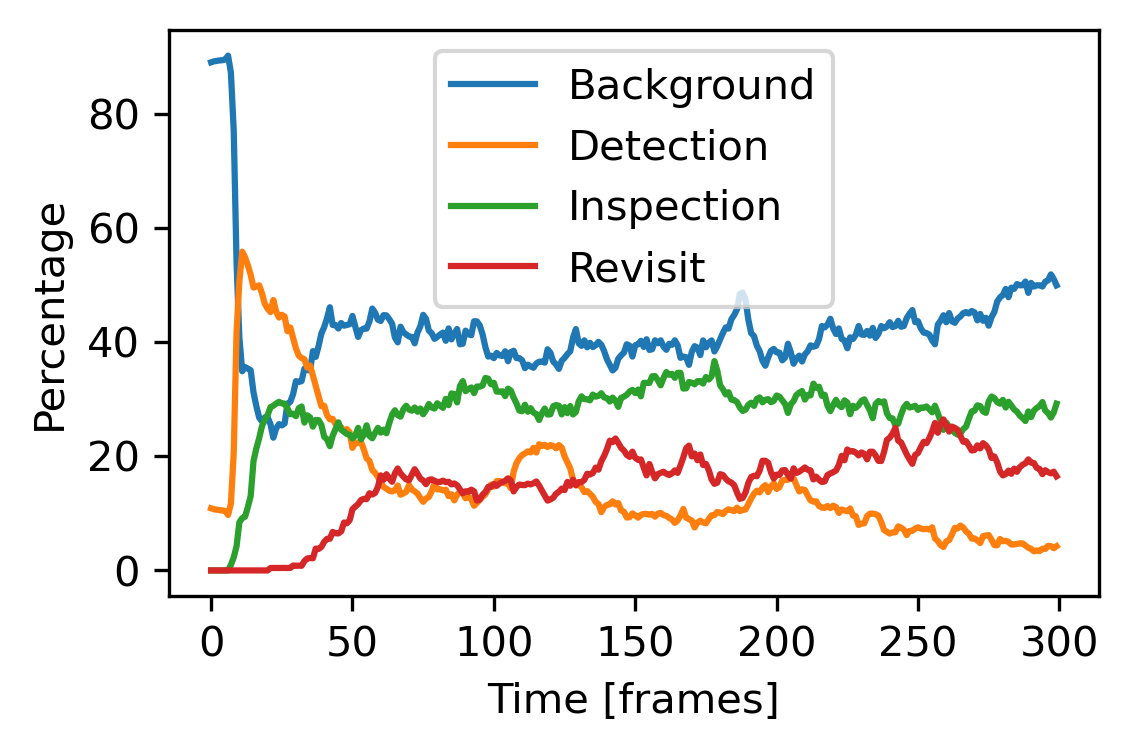

In [16]:
BDIR_per_frames = np.zeros((4,300))
bdir_to_row = {'B': 0, 'D': 1, 'I': 2, 'R': 3}
for index, row in VidCom.gt_foveation_df.iterrows():
    BDIR_per_frames[bdir_to_row[row['fov_category']], row['frame_start']:row['frame_end']+1] += 1
    
fig, ax = plt.subplots(dpi=150, figsize=(6,4))
combined_per_frames = np.sum(BDIR_per_frames, axis=0)
ax.plot(BDIR_per_frames[0], label='Background')
ax.plot(BDIR_per_frames[1], label='Detection')
ax.plot(BDIR_per_frames[2], label='Inspection')
ax.plot(BDIR_per_frames[3], label='Revisit')
ax.plot(combined_per_frames, ls=':', label='Combined')
ax.set(title='Ground truth foveation category over time', xlabel='Time [frames]', ylabel='Summed occurance')
plt.legend(loc=1); plt.show()
fig, ax = plt.subplots(dpi=300, figsize=(4,2.5))
ax.plot(BDIR_per_frames[0] / combined_per_frames * 100, label='Background')
ax.plot(BDIR_per_frames[1] / combined_per_frames * 100, label='Detection')
ax.plot(BDIR_per_frames[2] / combined_per_frames * 100, label='Inspection')
ax.plot(BDIR_per_frames[3] / combined_per_frames * 100, label='Revisit')
ax.set(xlabel='Time [frames]', ylabel='Percentage') # title='Ground truth foveation category over time', 
plt.legend(); plt.show()

...but this uses all the data from all videos, now split this up:

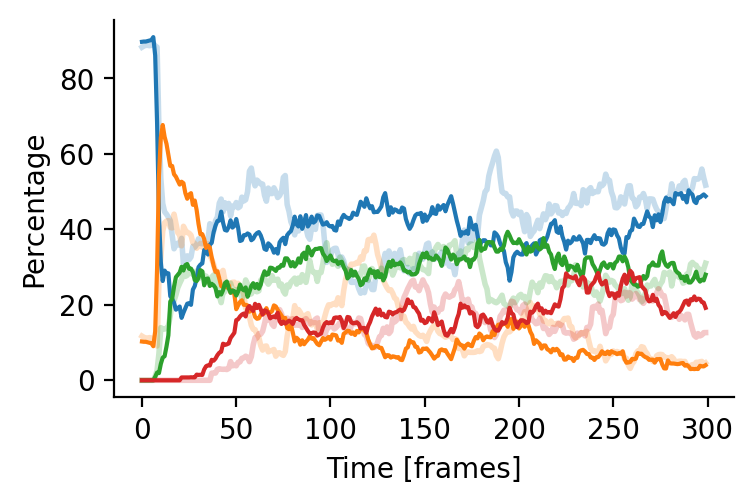

In [17]:
BDIR_per_frames_train = np.zeros((4,300))
BDIR_per_frames = np.zeros((4,300))
bdir_to_row = {'B': 0, 'D': 1, 'I': 2, 'R': 3}
for index, row in VidCom.train_foveation_df.iterrows():
    BDIR_per_frames_train[bdir_to_row[row['fov_category']], row['frame_start']:row['frame_end']+1] += 1
for index, row in VidCom.test_foveation_df.iterrows():
    BDIR_per_frames[bdir_to_row[row['fov_category']], row['frame_start']:row['frame_end']+1] += 1

combined_per_frames_train = np.sum(BDIR_per_frames_train, axis=0)
combined_per_frames = np.sum(BDIR_per_frames, axis=0)

fig, ax = plt.subplots(dpi=200, figsize=(4,2.5))
ax.plot(BDIR_per_frames_train[0] / combined_per_frames_train * 100, color=cl[0], lw=2, ls='-', alpha=0.25)
ax.plot(BDIR_per_frames_train[1] / combined_per_frames_train * 100, color=cl[1], lw=2, ls='-', alpha=0.25)
ax.plot(BDIR_per_frames_train[2] / combined_per_frames_train * 100, color=cl[2], lw=2, ls='-', alpha=0.25)
ax.plot(BDIR_per_frames_train[3] / combined_per_frames_train * 100, color=cl[3], lw=2, ls='-', alpha=0.25)
ax.plot(BDIR_per_frames[0] / combined_per_frames * 100, color=cl[0], label='Background')
ax.plot(BDIR_per_frames[1] / combined_per_frames * 100, color=cl[1], label='Detection')
ax.plot(BDIR_per_frames[2] / combined_per_frames * 100, color=cl[2], label='Inspection')
ax.plot(BDIR_per_frames[3] / combined_per_frames * 100, color=cl[3], label='Revisit')
ax.set(xlabel='Time [frames]', ylabel='Percentage') # title='Ground truth foveation category over time', 
# plt.legend(); 
sns.despine(); plt.show()


For the supplement, check the temporally resolved ratios for all models! 

a) Location-based, low-level features


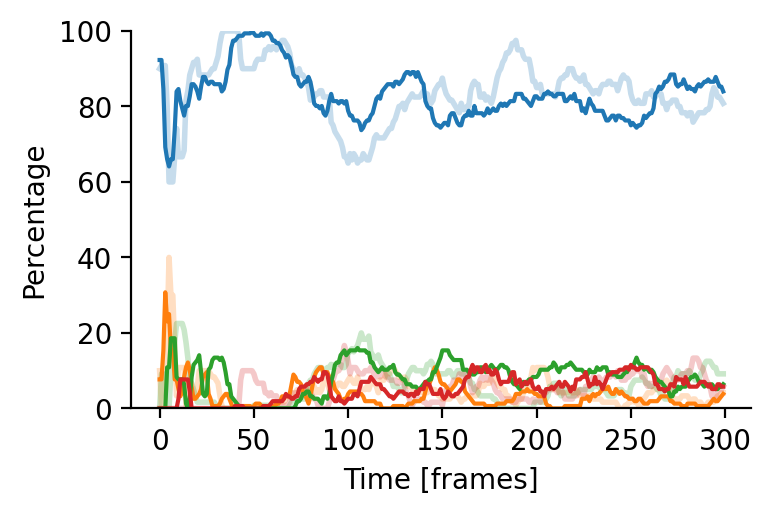

b) Location-based, high-level features


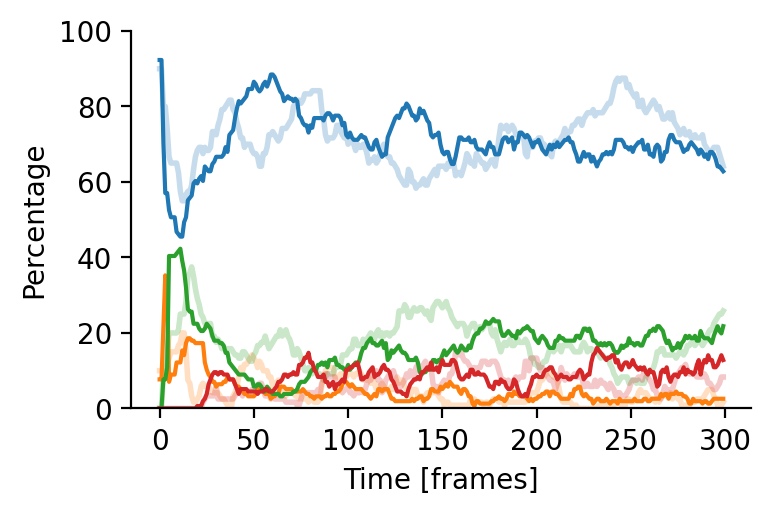

c) Object-based, low-level features


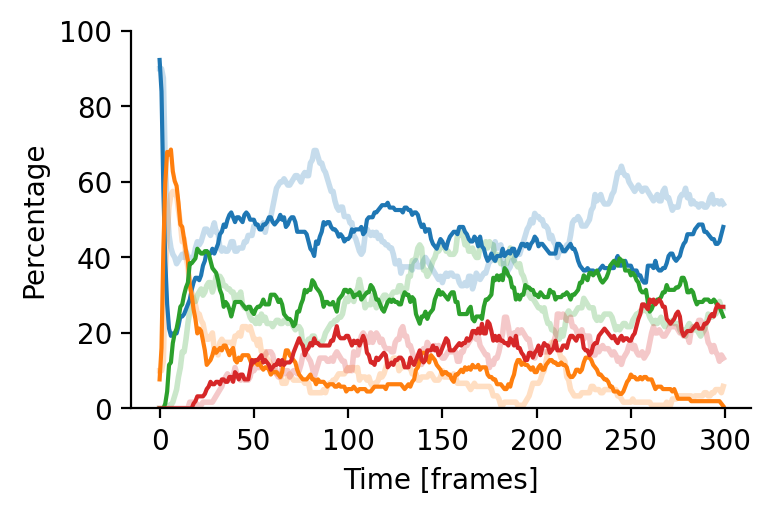

d) Object-based, only center bias


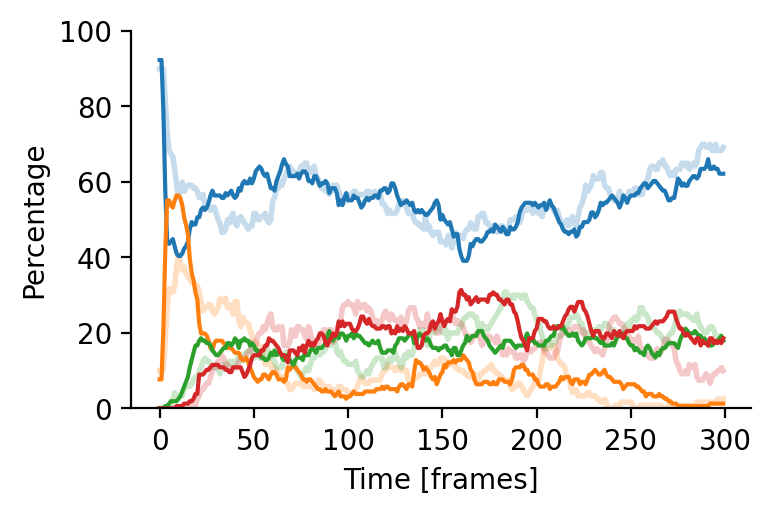

In [18]:
names = [
    'a) Location-based, low-level features',
    'b) Location-based, high-level features',
    'c) Object-based, low-level features',
    'd) Object-based, only center bias',
]
run_ids = [
    'pxDDM_train_molin_64-32-50_2022-12-14-02H-35M-35S_22026683',
    'pxDDM_train_TASEDnet_64-32-50_2022-12-14-02H-34M-38S_22026682',
    'objDDM_train_molin_64-32-50_2022-12-14-02H-36M-30S_22026684',
    'objDDM_train_None_64-32-50_2022-12-14-02H-37M-32S_22026685',
]

for model_idx in range(4):
    runid = run_ids[model_idx]
    name = names[model_idx]
    
    if 'objDDM' in runid:
        model = ObjDDModel(VidCom)
        parameters = ['ddm_thres', 'ddm_sig', 'att_dva', 'ior_decay', 'ior_inobj']
    elif 'pxDDM' in runid:
        model = PxlDDModel(VidCom)
        parameters = ['ddm_thres', 'ddm_sig', 'att_dva', 'ior_decay', 'ior_dva']
    else:
        raise NotImplementedError("Only Object- and Location-based are implemented")

    if os.path.isfile(f'results/{runid}/res_df_top{0}.csv'):
        model.result_df = pd.read_csv(f'results/{runid}/res_df_top{0}.csv')

    ratios = model.functional_event_courses(videos_to_eval="test")
    ratios_train = model.functional_event_courses(videos_to_eval="train")

    print(name)
    fig, ax = plt.subplots(dpi=200, figsize=(4,2.5))
    ax.plot(ratios_train[0], color=cl[0], lw=2, ls='-', alpha=0.25)
    ax.plot(ratios_train[1], color=cl[1], lw=2, ls='-', alpha=0.25)
    ax.plot(ratios_train[2], color=cl[2], lw=2, ls='-', alpha=0.25)
    ax.plot(ratios_train[3], color=cl[3], lw=2, ls='-', alpha=0.25)
    ax.plot(ratios[0], color=cl[0], label='Background')
    ax.plot(ratios[1], color=cl[1], label='Detection')
    ax.plot(ratios[2], color=cl[2], label='Inspection')
    ax.plot(ratios[3], color=cl[3], label='Revisit')
    # ax.set(title=name, xlabel='Time [frames]', ylabel='Percentage', ylim=[0,100]) # title='Ground truth foveation category over time', 
    ax.set(xlabel='Time [frames]', ylabel='Percentage', ylim=[0,100]) # title='Ground truth foveation category over time', 
    # if model_idx==0:
    #     plt.legend(); 
    sns.despine(); plt.show()

In main paper, reduce this to the barplot of the mean ratios, which is calculated afterwards.
First, look into the train/test boxplots!

## Fig 5: Boxplots


In [19]:
VidCom.get_foveation_ratio()

0.7839665164874551

MainProcess pypet.storageservice.HDF5StorageService INFO     I will use the hdf5 file `./data/hdf/evolution.hdf`.
MainProcess pypet.environment.Environment INFO     Environment initialized.
MainProcess root INFO     Evolution: Using algorithm: adaptive
MainProcess root INFO     Evolution: Individual generation: <function randomParametersAdaptive at 0x7feaf1d77830>
MainProcess root INFO     Evolution: Mating operator: <function cxBlend at 0x7feaf5e9a0e0>
MainProcess root INFO     Evolution: Mutation operator: <function gaussianAdaptiveMutation_nStepSizes at 0x7feaf1d77cb0>
MainProcess root INFO     Evolution: Parent selection: <function selRank at 0x7feaf1d779e0>
MainProcess root INFO     Evolution: Selection operator: <function selBest_multiObj at 0x7feaf1d77a70>


pxDDM_train_molin_64-32-50_2022-12-14-02H-35M-35S_22026683


MainProcess root INFO     Failed to drop_duplicates() without column name. Trying by column "id".


Train,  L.ll [0.83026823 0.05161806 0.06937066 0.04874306]
Test,  L.ll [0.83029447 0.03687233 0.08286392 0.04996928]
Test ratio to GT,  L.ll [2.05980732 0.25607405 0.28350079 0.31108756]
pxDDM_train_TASEDnet_64-32-50_2022-12-14-02H-34M-38S_22026682


MainProcess root INFO     Failed to drop_duplicates() without column name. Trying by column "id".


Train,  L.hl [0.69842622 0.04895486 0.18292014 0.06969878]
Test,  L.hl [0.70212206 0.04729634 0.16081597 0.08976563]
Test ratio to GT,  L.hl [1.74183523 0.32846761 0.55019673 0.5588427 ]
objDDM_train_molin_64-32-50_2022-12-14-02H-36M-30S_22026684


MainProcess root INFO     Failed to drop_duplicates() without column name. Trying by column "id".


Train,  O.ll [0.48281163 0.10046267 0.27259809 0.1441276 ]
Test,  O.ll [0.42650641 0.10768162 0.31457799 0.15123397]
Test ratio to GT,  O.ll [1.05808368 0.7478364  1.07625989 0.94151856]
objDDM_train_None_64-32-50_2022-12-14-02H-37M-32S_22026685


MainProcess root INFO     Failed to drop_duplicates() without column name. Trying by column "id".


Train,  O.cb [0.56793403 0.10330035 0.18902951 0.13973611]
Test,  O.cb [0.57241253 0.10053486 0.17748531 0.14956731]
Test ratio to GT,  O.cb [1.42004982 0.69820292 0.60722722 0.9311426 ]


NameError: name 'HandlerTuple' is not defined

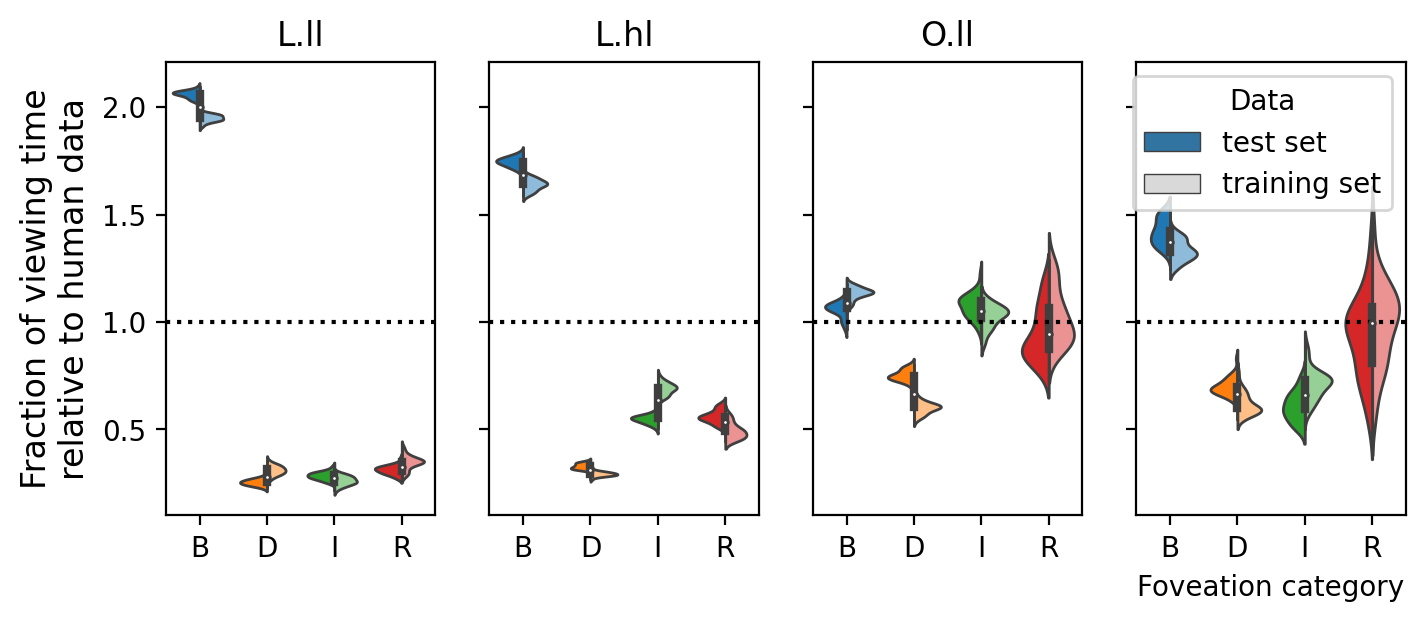

In [20]:
names = [
    'L.ll',
    'L.hl',
    'O.ll',
    'O.cb',
]
run_ids = [
    'pxDDM_train_molin_64-32-50_2022-12-14-02H-35M-35S_22026683',
    'pxDDM_train_TASEDnet_64-32-50_2022-12-14-02H-34M-38S_22026682',
    'objDDM_train_molin_64-32-50_2022-12-14-02H-36M-30S_22026684',
    'objDDM_train_None_64-32-50_2022-12-14-02H-37M-32S_22026685',
]
fig, axes = plt.subplots(1,4, sharex=True, sharey=True, figsize=(8,3), dpi=200)

correct_D_for_length = False

subjects_fovcat_train = list(VidCom.get_fovcat_ratio("train").values())
subjects_fovcat_test = list(VidCom.get_fovcat_ratio("test").values())
if correct_D_for_length:
    subjects_fovcat_train[1] = subjects_fovcat_train[1] * VidCom.get_foveation_ratio()
    subjects_fovcat_test[1] = subjects_fovcat_test[1] * VidCom.get_foveation_ratio()

mean_fovcats_train = []
mean_fovcats_test = []

evol = Evolution(lambda x: x, ParameterSpace(['mock'], [[0, 1]]))
for ax_i, ax in enumerate(axes.flat):
    runid = run_ids[ax_i]
    print(runid)
    DILLNAME = f'{runid}.dill'
    if 'objDDM' in runid:
        model = ObjDDModel(VidCom)
        parameters = ['ddm_thres', 'ddm_sig', 'att_dva', 'ior_decay', 'ior_inobj']
    elif 'pxDDM' in runid:
        model = PxlDDModel(VidCom)
        parameters = ['ddm_thres', 'ddm_sig', 'att_dva', 'ior_decay', 'ior_dva']
    evol = evol.loadEvolution(f'results/{runid}/{DILLNAME}')
    df_evol = evol.dfEvolution(outputs=True).copy()
    df_top32 = df_evol.sort_values('score', ascending=False)[:32]
    # read in test simulation results
    test_fovcats = []
    for i in range(32):
        model.result_df = pd.read_csv(f'results/{runid}/testres_df_top{i}.csv')
        test_fovcats.append(np.array(list(model.get_fovcat_ratio().values())) )
    df_top32['test_fov_cat'] = test_fovcats

    fovcats_train = [df_top32['fov_cat'].iloc[indv] for indv in range(32)]
    mean_fovcats_train.append(np.mean(np.array(fovcats_train), axis=0))
    print("Train, ", names[ax_i], np.mean(np.array(fovcats_train), axis=0))
    train_rel_fovcat = [df_top32['fov_cat'].iloc[indv] / np.array(subjects_fovcat_train) for indv in range(32)]
    
    fovcats_test = [df_top32['test_fov_cat'].iloc[indv] for indv in range(32)]
    mean_fovcats_test.append(np.mean(np.array(fovcats_test), axis=0))
    print("Test, ", names[ax_i], np.mean(np.array(fovcats_test), axis=0))
    print("Test ratio to GT, ", names[ax_i], np.mean(np.array(fovcats_test), axis=0) / np.array(subjects_fovcat_test))
    test_rel_fovcat = [df_top32['test_fov_cat'].iloc[indv] / np.array(subjects_fovcat_test) for indv in range(32)]
    df_train_fovcats_rel_gt = pd.DataFrame(index=[f'Indv. Top {t}' for t in range(32)] , 
                                     columns=['B', 'D', 'I', 'R'], data=train_rel_fovcat
                                     ).assign(Data='training set')
    df_test_fovcats_rel_gt = pd.DataFrame(index=[f'Indv. Top {t}' for t in range(32)] , 
                                          columns=['B', 'D', 'I', 'R'], data=test_rel_fovcat
                                          ).assign(Data='test set')
    cdf = pd.concat([df_test_fovcats_rel_gt, df_train_fovcats_rel_gt])
    mdf = pd.melt(cdf, id_vars=['Data'], var_name=['Foveation category'])

    sns.violinplot(x="Foveation category", y="value", hue="Data", data=mdf, ax=ax, split=True, linewidth=1, palette={"test set": cl[0], "training set": ".85"})    
    # df_fovcats_rel_gt.boxplot(ax=ax, grid=False)
    handles = []
    for ind, violin in enumerate(ax.findobj(PolyCollection)):
        rgb = to_rgb(cl[ind // 2])
        if ind % 2 != 0:
            rgb = 0.5 + 0.5 * np.array(rgb)  # make whiter
        violin.set_facecolor(rgb)
        handles.append(plt.Rectangle((0, 0), 0, 0, facecolor=rgb, edgecolor=rgb))
    ax.set_yticks([0.5,1,1.5,2])
    ax.axhline(1, color='k', ls=':')

    if (ax_i%4)==0:
        ax.set_ylabel('Fraction of viewing time\nrelative to human data', size=12)
        # ax.set_xlabel('Fov. category', size=14)
    else:
        ax.set_ylabel('')
    if ax_i==3:
        ax.legend(bbox_to_anchor=(1,1), loc='upper right', 
                  frameon=False, handles=[tuple(handles[::2]), tuple(handles[1::2])], labels=["Test set", "Training set"],
                  title="", handlelength=3, handler_map={tuple: HandlerTuple(ndivide=None, pad=0)}, fontsize=9)
    else:
        ax.get_legend().remove()
    ax.set_xlabel('')
    ax.set_title(names[ax_i])
fig.text(0.55, 0.0, 'Foveation category', size=12, ha='center')    
plt.tight_layout()
sns.despine(); plt.show()

Trainset


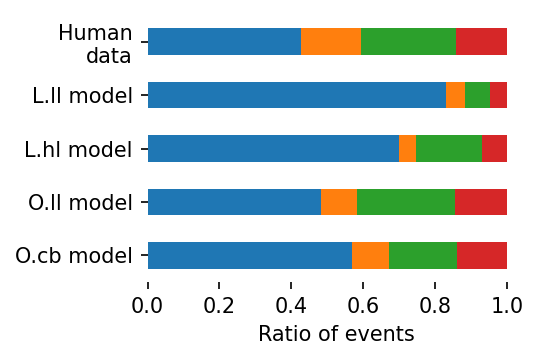

Testset


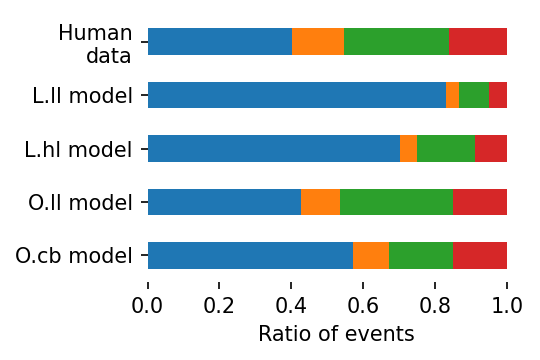

In [27]:
# names_r = names[::-1]
names_r = ["O.cb model", "O.ll model", "L.hl model", "L.ll model"]
mean_fovcats_train_r = mean_fovcats_train[::-1]
mean_fovcats_test_r = mean_fovcats_test[::-1]

subjects_fovcat_train = list(VidCom.get_fovcat_ratio("train").values())
subjects_fovcat_train = list(VidCom.get_fovcat_ratio("train").values())
if correct_D_for_length: # --> FALSE!
    subjects_fovcat_train[1] = subjects_fovcat_train[1] * VidCom.get_foveation_ratio()
    subjects_fovcat_test[1] = subjects_fovcat_test[1] * VidCom.get_foveation_ratio()

df_fovcats_train = pd.DataFrame(index=names_r + ['Human\ndata'], 
                        columns=['B', 'D*', 'I', 'R'],
                        data= mean_fovcats_train_r + [subjects_fovcat_train/sum(subjects_fovcat_train)])
df_fovcats_test = pd.DataFrame(index=names_r + ['Human\ndata'], 
                        columns=['B', 'D*', 'I', 'R'],
                        data= mean_fovcats_test_r + [subjects_fovcat_test/sum(subjects_fovcat_test)])

# fig, ax = plt.subplots(figsize=(3.5,2.5),dpi=150)
fig, ax = plt.subplots(figsize=(3.7,2.5),dpi=150)
df_fovcats_train.plot.barh(stacked=True, ax=ax,rot=0, legend=False)#.legend(bbox_to_anchor=(0.3, 1.5))
ax.set_frame_on(False); ax.set(xlabel = 'Ratio of events')#, title = 'Trainset')
print("Trainset")
plt.tight_layout(); plt.show()
fig, ax = plt.subplots(figsize=(3.7,2.5),dpi=150)
df_fovcats_test.plot.barh(stacked=True, ax=ax,rot=0, legend=False)#.legend(bbox_to_anchor=(0.3, 1.5))
ax.set_frame_on(False); ax.set(xlabel = 'Ratio of events')#, title = 'Testset')
print("Testset")
plt.tight_layout(); plt.show()


MainProcess root INFO     weightList not set, assuming single fitness value to be maximized.
MainProcess root INFO     Trajectory Name: results-2023-02-27-14H-10M-55S
MainProcess root INFO     Storing data to: ./data/hdf/evolution.hdf
MainProcess root INFO     Trajectory Name: results-2023-02-27-14H-10M-55S
MainProcess root INFO     Number of cores: 40
MainProcess pypet.storageservice.HDF5StorageService INFO     I will use the hdf5 file `./data/hdf/evolution.hdf`.
MainProcess pypet.environment.Environment INFO     Environment initialized.
MainProcess root INFO     Evolution: Using algorithm: adaptive
/home/users/n/nicolas-roth/miniconda3/envs/venv/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMulti' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/users/n/nicolas-roth/miniconda3/envs/venv/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A 

pxDDM_train_molin_64-32-50_2022-12-14-02H-35M-35S_22026683


MainProcess root INFO     Failed to drop_duplicates() without column name. Trying by column "id".


Train,  L.ll [0.83026823 0.05161806 0.06937066 0.04874306]
Test,  L.ll [0.83029447 0.03687233 0.08286392 0.04996928]
Test ratio to GT,  L.ll [2.05980732 0.25607405 0.28350079 0.31108756]
test 2.0951758378835974 0.22852823756728993
pxDDM_train_TASEDnet_64-32-50_2022-12-14-02H-34M-38S_22026682


MainProcess root INFO     Failed to drop_duplicates() without column name. Trying by column "id".


Train,  L.hl [0.69842622 0.04895486 0.18292014 0.06969878]
Test,  L.hl [0.70212206 0.04729634 0.16081597 0.08976563]
Test ratio to GT,  L.hl [1.74183523 0.32846761 0.55019673 0.5588427 ]
test 1.7874063017734856 0.30999707031043433
objDDM_train_molin_64-32-50_2022-12-14-02H-36M-30S_22026684


MainProcess root INFO     Failed to drop_duplicates() without column name. Trying by column "id".


Train,  O.ll [0.48281163 0.10046267 0.27259809 0.1441276 ]
Test,  O.ll [0.42650641 0.10768162 0.31457799 0.15123397]
Test ratio to GT,  O.ll [1.05808368 0.7478364  1.07625989 0.94151856]
test 1.2244240458045073 0.6648094183775708
objDDM_train_None_64-32-50_2022-12-14-02H-37M-32S_22026685


MainProcess root INFO     Failed to drop_duplicates() without column name. Trying by column "id".


Train,  O.cb [0.56793403 0.10330035 0.18902951 0.13973611]
Test,  O.cb [0.57241253 0.10053486 0.17748531 0.14956731]
Test ratio to GT,  O.cb [1.42004982 0.69820292 0.60722722 0.9311426 ]
test 1.522520946633591 0.5007645061651963


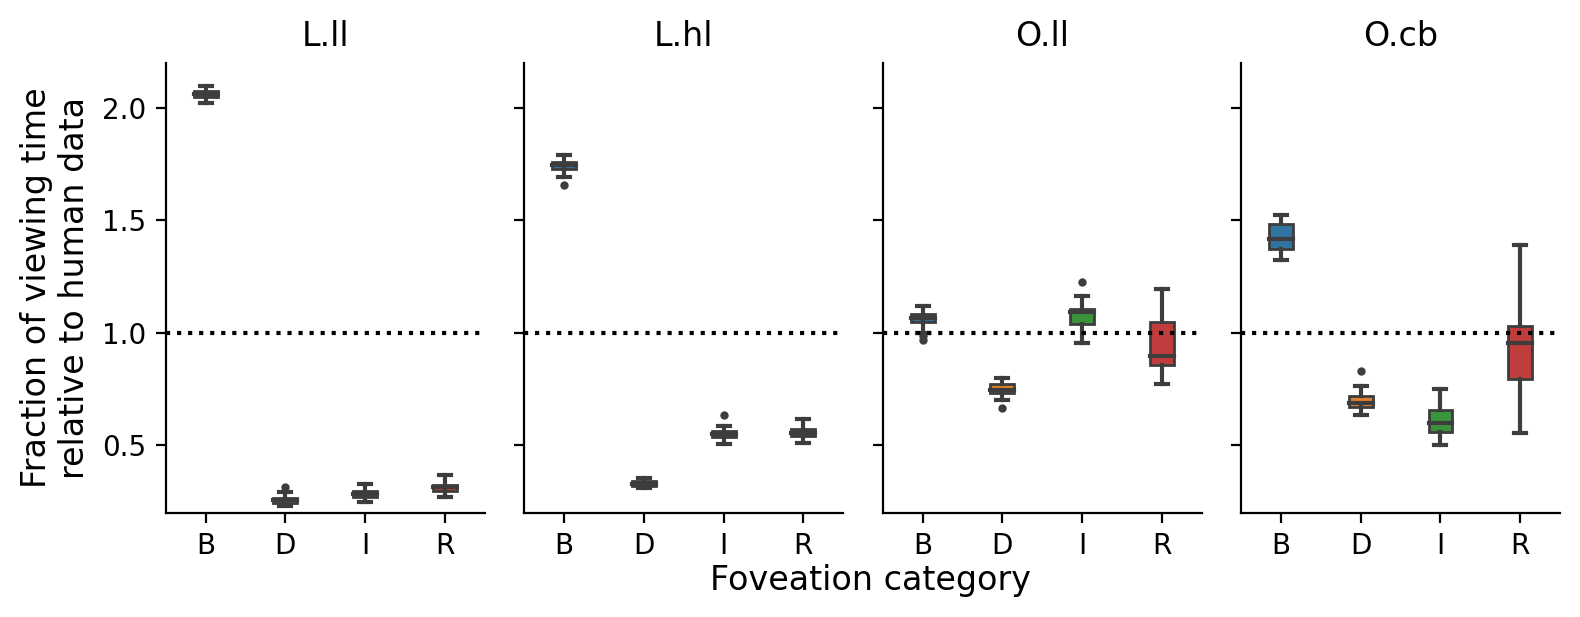

In [100]:
names = [
    'L.ll',
    'L.hl',
    'O.ll',
    'O.cb',
]
run_ids = [
    'pxDDM_train_molin_64-32-50_2022-12-14-02H-35M-35S_22026683',
    'pxDDM_train_TASEDnet_64-32-50_2022-12-14-02H-34M-38S_22026682',
    'objDDM_train_molin_64-32-50_2022-12-14-02H-36M-30S_22026684',
    'objDDM_train_None_64-32-50_2022-12-14-02H-37M-32S_22026685',
]
fig, axes = plt.subplots(1,4, sharex=True, sharey=True, figsize=(8,3), dpi=200)

correct_D_for_length = False

subjects_fovcat_train = list(VidCom.get_fovcat_ratio("train").values())
subjects_fovcat_test = list(VidCom.get_fovcat_ratio("test").values())
mean_fovcats_test = []

evol = Evolution(lambda x: x, ParameterSpace(['mock'], [[0, 1]]))
for ax_i, ax in enumerate(axes.flat):
    runid = run_ids[ax_i]
    print(runid)
    DILLNAME = f'{runid}.dill'
    if 'objDDM' in runid:
        model = ObjDDModel(VidCom)
        parameters = ['ddm_thres', 'ddm_sig', 'att_dva', 'ior_decay', 'ior_inobj']
    elif 'pxDDM' in runid:
        model = PxlDDModel(VidCom)
        parameters = ['ddm_thres', 'ddm_sig', 'att_dva', 'ior_decay', 'ior_dva']
    evol = evol.loadEvolution(f'results/{runid}/{DILLNAME}')
    df_evol = evol.dfEvolution(outputs=True).copy()
    df_top32 = df_evol.sort_values('score', ascending=False)[:32]
    # read in test simulation results
    test_fovcats = []
    for i in range(32):
        model.result_df = pd.read_csv(f'results/{runid}/testres_df_top{i}.csv')
        test_fovcats.append(np.array(list(model.get_fovcat_ratio().values())) )
    df_top32['test_fov_cat'] = test_fovcats

    fovcats_train = [df_top32['fov_cat'].iloc[indv] for indv in range(32)]
    mean_fovcats_train.append(np.mean(np.array(fovcats_train), axis=0))
    print("Train, ", names[ax_i], np.mean(np.array(fovcats_train), axis=0))
    train_rel_fovcat = [df_top32['fov_cat'].iloc[indv] / np.array(subjects_fovcat_train) for indv in range(32)]
    
    fovcats_test = [df_top32['test_fov_cat'].iloc[indv] for indv in range(32)]
    mean_fovcats_test.append(np.mean(np.array(fovcats_test), axis=0))
    print("Test, ", names[ax_i], np.mean(np.array(fovcats_test), axis=0))
    print("Test ratio to GT, ", names[ax_i], np.mean(np.array(fovcats_test), axis=0) / np.array(subjects_fovcat_test))
    test_rel_fovcat = [df_top32['test_fov_cat'].iloc[indv] / np.array(subjects_fovcat_test) for indv in range(32)]
    df_train_fovcats_rel_gt = pd.DataFrame(index=[f'Indv. Top {t}' for t in range(32)] , 
                                     columns=['B', 'D', 'I', 'R'], data=train_rel_fovcat
                                     ).assign(Data='trainset')
    df_test_fovcats_rel_gt = pd.DataFrame(index=[f'Indv. Top {t}' for t in range(32)] , 
                                          columns=['B', 'D', 'I', 'R'], data=test_rel_fovcat
                                          ).assign(Data='testset')
    
    sns.boxplot(data=df_test_fovcats_rel_gt, width=0.3, ax=ax, boxprops={"linewidth": 1}, flierprops={"marker": "o", "markersize" : 2})
    print("test", df_test_fovcats_rel_gt.max()[:-1].max(), df_test_fovcats_rel_gt.min()[:-1].min())
    #ax.set_yscale('log')
    ax.set_yticks([0.5,1,1.5,2])
    ax.axhline(1, color='k', ls=':')
    if (ax_i%4)==0:
        ax.set_ylabel('Fraction of viewing time\nrelative to human data', size=12)
        # ax.set_xlabel('Fov. category', size=14)
    else:
        ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_title(names[ax_i])
    ax.set_ylim(0.2, 2.2)
fig.text(0.55, 0.0, 'Foveation category', size=12, ha='center')    
plt.tight_layout()
sns.despine(); plt.show()

MainProcess root INFO     weightList not set, assuming single fitness value to be maximized.
MainProcess root INFO     Trajectory Name: results-2023-02-27-14H-11M-18S
MainProcess root INFO     Storing data to: ./data/hdf/evolution.hdf
MainProcess root INFO     Trajectory Name: results-2023-02-27-14H-11M-18S
MainProcess root INFO     Number of cores: 40
MainProcess pypet.storageservice.HDF5StorageService INFO     I will use the hdf5 file `./data/hdf/evolution.hdf`.
MainProcess pypet.environment.Environment INFO     Environment initialized.
MainProcess root INFO     Evolution: Using algorithm: adaptive
/home/users/n/nicolas-roth/miniconda3/envs/venv/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMulti' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/users/n/nicolas-roth/miniconda3/envs/venv/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A 

pxDDM_train_molin_64-32-50_2022-12-14-02H-35M-35S_22026683


MainProcess root INFO     Failed to drop_duplicates() without column name. Trying by column "id".


Train,  L.ll [0.83026823 0.05161806 0.06937066 0.04874306]
Test,  L.ll [0.83029447 0.03687233 0.08286392 0.04996928]
Test ratio to GT,  L.ll [2.05980732 0.25607405 0.28350079 0.31108756]
train
pxDDM_train_TASEDnet_64-32-50_2022-12-14-02H-34M-38S_22026682


MainProcess root INFO     Failed to drop_duplicates() without column name. Trying by column "id".


Train,  L.hl [0.69842622 0.04895486 0.18292014 0.06969878]
Test,  L.hl [0.70212206 0.04729634 0.16081597 0.08976563]
Test ratio to GT,  L.hl [1.74183523 0.32846761 0.55019673 0.5588427 ]
train
objDDM_train_molin_64-32-50_2022-12-14-02H-36M-30S_22026684


MainProcess root INFO     Failed to drop_duplicates() without column name. Trying by column "id".


Train,  O.ll [0.48281163 0.10046267 0.27259809 0.1441276 ]
Test,  O.ll [0.42650641 0.10768162 0.31457799 0.15123397]
Test ratio to GT,  O.ll [1.05808368 0.7478364  1.07625989 0.94151856]
train
objDDM_train_None_64-32-50_2022-12-14-02H-37M-32S_22026685


MainProcess root INFO     Failed to drop_duplicates() without column name. Trying by column "id".


Train,  O.cb [0.56793403 0.10330035 0.18902951 0.13973611]
Test,  O.cb [0.57241253 0.10053486 0.17748531 0.14956731]
Test ratio to GT,  O.cb [1.42004982 0.69820292 0.60722722 0.9311426 ]
train


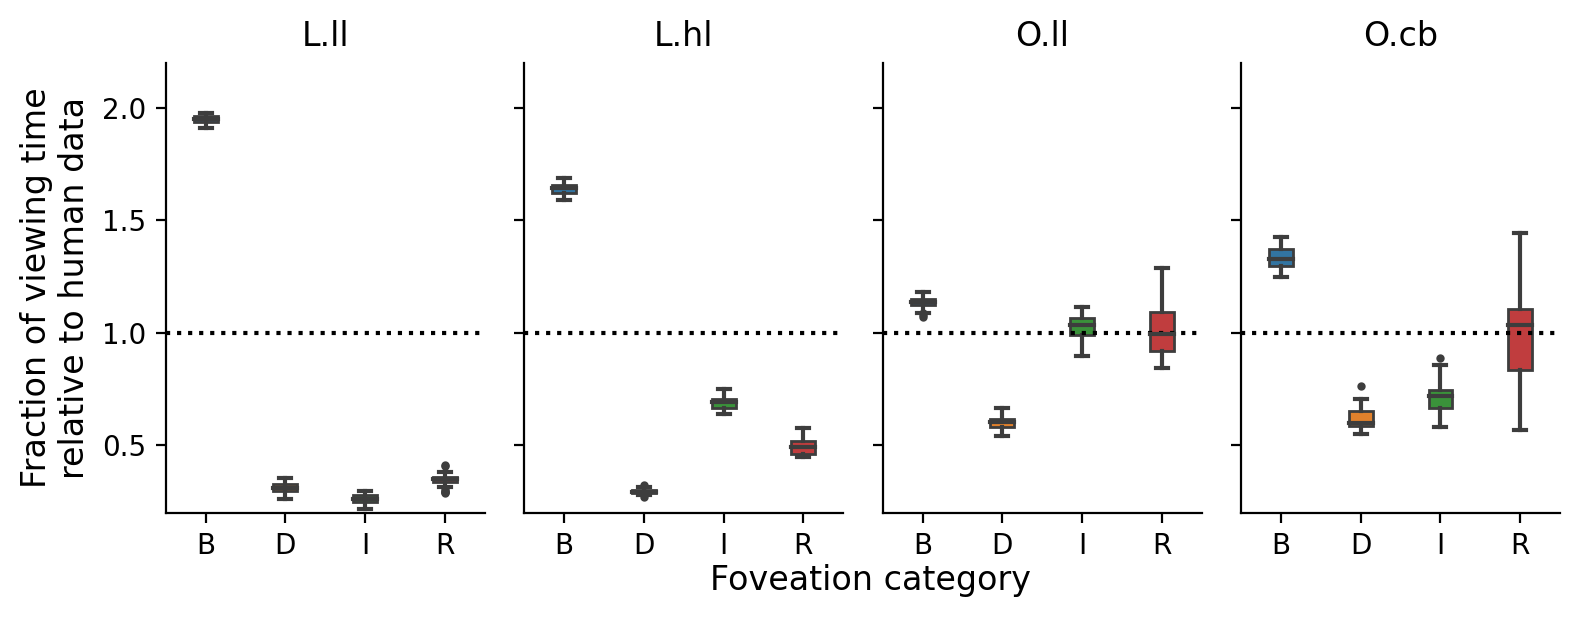

In [101]:
names = [
    'L.ll',
    'L.hl',
    'O.ll',
    'O.cb',
]
run_ids = [
    'pxDDM_train_molin_64-32-50_2022-12-14-02H-35M-35S_22026683',
    'pxDDM_train_TASEDnet_64-32-50_2022-12-14-02H-34M-38S_22026682',
    'objDDM_train_molin_64-32-50_2022-12-14-02H-36M-30S_22026684',
    'objDDM_train_None_64-32-50_2022-12-14-02H-37M-32S_22026685',
]
fig, axes = plt.subplots(1,4, sharex=True, sharey=True, figsize=(8,3), dpi=200)

correct_D_for_length = False

subjects_fovcat_train = list(VidCom.get_fovcat_ratio("train").values())
subjects_fovcat_test = list(VidCom.get_fovcat_ratio("test").values())
mean_fovcats_test = []

evol = Evolution(lambda x: x, ParameterSpace(['mock'], [[0, 1]]))
for ax_i, ax in enumerate(axes.flat):
    runid = run_ids[ax_i]
    print(runid)
    DILLNAME = f'{runid}.dill'
    if 'objDDM' in runid:
        model = ObjDDModel(VidCom)
        parameters = ['ddm_thres', 'ddm_sig', 'att_dva', 'ior_decay', 'ior_inobj']
    elif 'pxDDM' in runid:
        model = PxlDDModel(VidCom)
        parameters = ['ddm_thres', 'ddm_sig', 'att_dva', 'ior_decay', 'ior_dva']
    evol = evol.loadEvolution(f'results/{runid}/{DILLNAME}')
    df_evol = evol.dfEvolution(outputs=True).copy()
    df_top32 = df_evol.sort_values('score', ascending=False)[:32]
    # read in test simulation results
    test_fovcats = []
    for i in range(32):
        model.result_df = pd.read_csv(f'results/{runid}/testres_df_top{i}.csv')
        test_fovcats.append(np.array(list(model.get_fovcat_ratio().values())) )
    df_top32['test_fov_cat'] = test_fovcats

    fovcats_train = [df_top32['fov_cat'].iloc[indv] for indv in range(32)]
    mean_fovcats_train.append(np.mean(np.array(fovcats_train), axis=0))
    print("Train, ", names[ax_i], np.mean(np.array(fovcats_train), axis=0))
    train_rel_fovcat = [df_top32['fov_cat'].iloc[indv] / np.array(subjects_fovcat_train) for indv in range(32)]
    
    fovcats_test = [df_top32['test_fov_cat'].iloc[indv] for indv in range(32)]
    mean_fovcats_test.append(np.mean(np.array(fovcats_test), axis=0))
    print("Test, ", names[ax_i], np.mean(np.array(fovcats_test), axis=0))
    print("Test ratio to GT, ", names[ax_i], np.mean(np.array(fovcats_test), axis=0) / np.array(subjects_fovcat_test))
    test_rel_fovcat = [df_top32['test_fov_cat'].iloc[indv] / np.array(subjects_fovcat_test) for indv in range(32)]
    df_train_fovcats_rel_gt = pd.DataFrame(index=[f'Indv. Top {t}' for t in range(32)] , 
                                     columns=['B', 'D', 'I', 'R'], data=train_rel_fovcat
                                     ).assign(Data='trainset')
    df_test_fovcats_rel_gt = pd.DataFrame(index=[f'Indv. Top {t}' for t in range(32)] , 
                                          columns=['B', 'D', 'I', 'R'], data=test_rel_fovcat
                                          ).assign(Data='testset')
    
    sns.boxplot(data=df_train_fovcats_rel_gt, width=0.3, ax=ax, boxprops={"linewidth": 1}, flierprops={"marker": "o", "markersize" : 2})
    # print("test", df_test_fovcats_rel_gt.max()[:-1].max(), df_test_fovcats_rel_gt.min()[:-1].min())
    print('train')
    #ax.set_yscale('log')
    ax.set_yticks([0.5,1,1.5,2])
    ax.axhline(1, color='k', ls=':')
    if (ax_i%4)==0:
        ax.set_ylabel('Fraction of viewing time\nrelative to human data', size=12)
        # ax.set_xlabel('Fov. category', size=14)
    else:
        ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_title(names[ax_i])
    ax.set_ylim(0.2, 2.2)
fig.text(0.55, 0.0, 'Foveation category', size=12, ha='center')    
plt.tight_layout()
sns.despine()
plt.savefig('train_fovcats_rel_gt_transp.png', dpi=200, transparent=True)
plt.show()

In [94]:
# get the max value in df_test_fovcats_rel_gt ignoring 
max_val = df_test_fovcats_rel_gt.max()[:-1].max()

In [95]:
max_val

1.522520946633591

<AxesSubplot:>

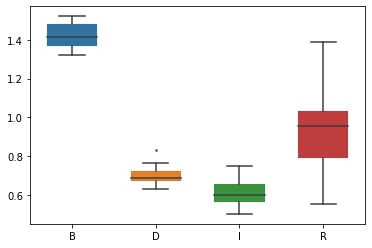

In [68]:
sns.boxplot(data=df_test_fovcats_rel_gt, width=0.6,  boxprops={"linewidth": 0.1}, flierprops={"marker": "x", "markersize" : 2})

In [ ]:
sns.boxplot(x="Foveation category", y="value", hue="Data", data=mdf, ax=ax)    # df_fovcats_rel_gt.boxplot(ax=ax, grid=False)

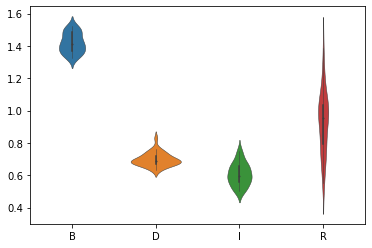

In [71]:
sns.violinplot(data=df_test_fovcats_rel_gt, width=0.6, linewidth=0.5) #, flierprops={"marker": "x"})
plt.savefig('test_fovcats_rel_gt.png', dpi=200, transparent=True)

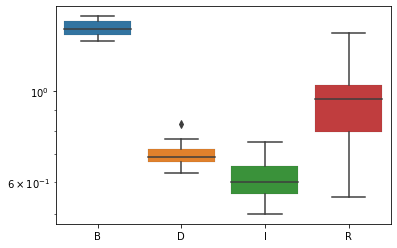

In [63]:
sns.boxplot(data=df_test_fovcats_rel_gt, boxprops={"linewidth": 0.1})
plt.yscale('log')

In [52]:
correct_D_for_length

False

Trainset


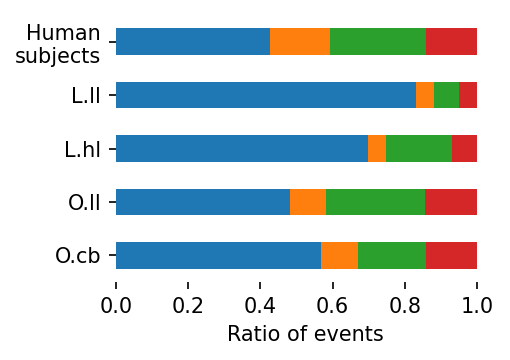

Testset


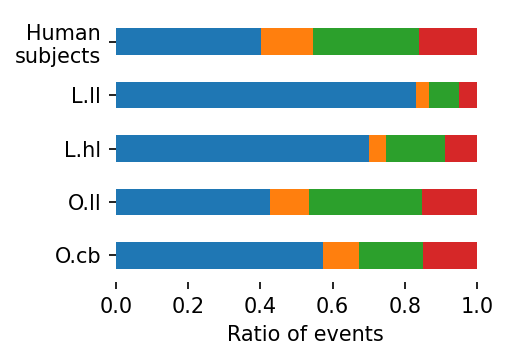

In [60]:
# names_r = names[::-1]
names_r = ["O.cb", "O.ll", "L.hl", "L.ll"]
mean_fovcats_train_r = mean_fovcats_train[::-1]
mean_fovcats_test_r = mean_fovcats_test[::-1]

subjects_fovcat_train = list(VidCom.get_fovcat_ratio("train").values())
subjects_fovcat_train = list(VidCom.get_fovcat_ratio("train").values())
if correct_D_for_length: # --> FALSE!
    subjects_fovcat_train[1] = subjects_fovcat_train[1] * VidCom.get_foveation_ratio()
    subjects_fovcat_test[1] = subjects_fovcat_test[1] * VidCom.get_foveation_ratio()

df_fovcats_train = pd.DataFrame(index=names_r + ['Human\nsubjects'], 
                        columns=['B', 'D*', 'I', 'R'],
                        data= mean_fovcats_train_r + [subjects_fovcat_train/sum(subjects_fovcat_train)])
df_fovcats_test = pd.DataFrame(index=names_r + ['Human\nsubjects'], 
                        columns=['B', 'D*', 'I', 'R'],
                        data= mean_fovcats_test_r + [subjects_fovcat_test/sum(subjects_fovcat_test)])

fig, ax = plt.subplots(figsize=(3.5,2.5),dpi=150)
df_fovcats_train.plot.barh(stacked=True, ax=ax,rot=0, legend=False)#.legend(bbox_to_anchor=(0.3, 1.5))
ax.set_frame_on(False); ax.set(xlabel = 'Ratio of events')#, title = 'Trainset')
print("Trainset")
plt.tight_layout(); plt.show()
fig, ax = plt.subplots(figsize=(3.5,2.5),dpi=150)
df_fovcats_test.plot.barh(stacked=True, ax=ax,rot=0, legend=False)#.legend(bbox_to_anchor=(0.3, 1.5))
ax.set_frame_on(False); ax.set(xlabel = 'Ratio of events')#, title = 'Testset')
print("Testset")
plt.tight_layout(); plt.show()


Trainset


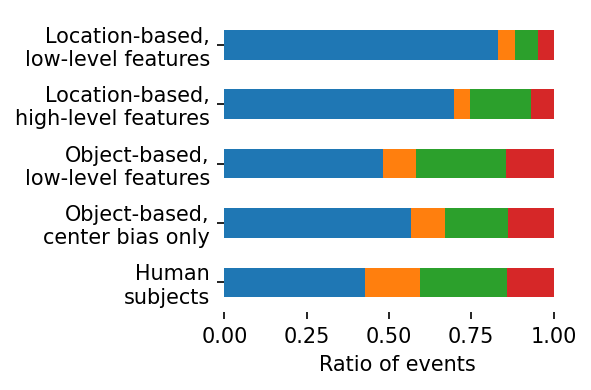

Testset


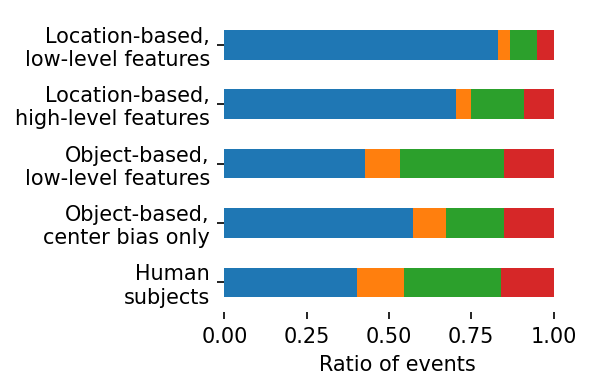

In [26]:
# names_r = names[::-1]
names_r = ["O.cb", "O.ll", "L.hl", "L.ll"]
mean_fovcats_train_r = mean_fovcats_train[::-1]
mean_fovcats_test_r = mean_fovcats_test[::-1]

subjects_fovcat_train = list(VidCom.get_fovcat_ratio("train").values())
subjects_fovcat_train = list(VidCom.get_fovcat_ratio("train").values())
if correct_D_for_length: # --> FALSE!
    subjects_fovcat_train[1] = subjects_fovcat_train[1] * VidCom.get_foveation_ratio()
    subjects_fovcat_test[1] = subjects_fovcat_test[1] * VidCom.get_foveation_ratio()

df_fovcats_train = pd.DataFrame(index=names_r + ['Human\nsubjects'], 
                        columns=['B', 'D*', 'I', 'R'],
                        data= mean_fovcats_train_r + [subjects_fovcat_train/sum(subjects_fovcat_train)])
df_fovcats_test = pd.DataFrame(index=['Human\nsubjects'] + names_r, 
                        columns=['B', 'D*', 'I', 'R'],
                        data= mean_fovcats_test_r + [subjects_fovcat_test/sum(subjects_fovcat_test)])

fig, ax = plt.subplots(figsize=(4,2.7),dpi=150)
df_fovcats_train.plot.barh(stacked=True, ax=ax,rot=0, legend=False)#.legend(bbox_to_anchor=(0.3, 1.5))
ax.set_frame_on(False); ax.set(xlabel = 'Ratio of events')#, title = 'Trainset')
print("Trainset")
plt.tight_layout(); plt.show()
fig, ax = plt.subplots(figsize=(4,2.7),dpi=150)
df_fovcats_test.plot.barh(stacked=True, ax=ax,rot=0, legend=False)#.legend(bbox_to_anchor=(0.3, 1.5))
ax.set_frame_on(False); ax.set(xlabel = 'Ratio of events')#, title = 'Testset')
print("Testset")
plt.tight_layout(); plt.show()


## Optimization with 3 objectives / F2

MainProcess root INFO     weightList not set, assuming single fitness value to be maximized.
MainProcess root INFO     Trajectory Name: results-2022-12-20-01H-48M-34S
MainProcess root INFO     Storing data to: ./data/hdf/evolution.hdf
MainProcess root INFO     Trajectory Name: results-2022-12-20-01H-48M-34S
MainProcess root INFO     Number of cores: 40
MainProcess pypet.storageservice.HDF5StorageService INFO     I will use the hdf5 file `./data/hdf/evolution.hdf`.
MainProcess pypet.environment.Environment INFO     Environment initialized.
MainProcess root INFO     Evolution: Using algorithm: adaptive
/home/users/n/nicolas-roth/miniconda3/envs/venv/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMulti' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/users/n/nicolas-roth/miniconda3/envs/venv/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A 

pxDDM_train_molin_wFovCat_64-32-50_2022-12-15-17H-06M-38S_22029113


MainProcess root INFO     Failed to drop_duplicates() without column name. Trying by column "id".


Train,  Location-based,
low-level features [0.78258333 0.05408507 0.10068924 0.06264236]
pxDDM_train_TASEDnet_wFovCat_64-32-50_2022-12-15-17H-07M-00S_22029114


MainProcess root INFO     Failed to drop_duplicates() without column name. Trying by column "id".


Train,  Location-based,
high-level features [0.58221094 0.05747743 0.26839757 0.09191406]
objDDM_train_molin_wFovCat_64-32-50_2022-12-15-17H-06M-23S_22029112


MainProcess root INFO     Failed to drop_duplicates() without column name. Trying by column "id".


Train,  Object-based,
low-level features [0.46708333 0.10628733 0.27254253 0.15408681]
objDDM_train_None_wFovCat_64-32-50_2022-12-15-17H-05M-50S_22029111


MainProcess root INFO     Failed to drop_duplicates() without column name. Trying by column "id".


Train,  Object-based,
center bias only [0.51744792 0.09121181 0.25169531 0.13964497]


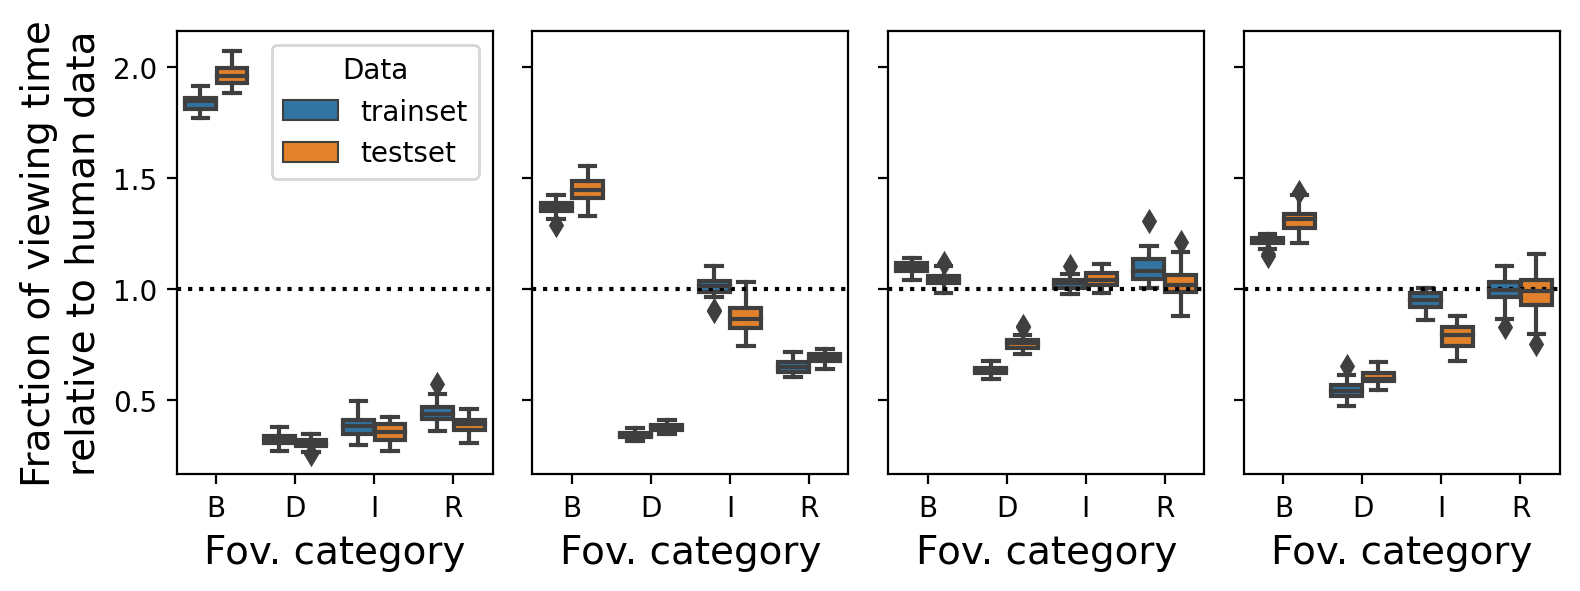

In [31]:
names = [
    'Location-based,\nlow-level features',
    'Location-based,\nhigh-level features',
    'Object-based,\nlow-level features',
    'Object-based,\ncenter bias only',
]

run_ids = [
    'pxDDM_train_molin_wFovCat_64-32-50_2022-12-15-17H-06M-38S_22029113',
    'pxDDM_train_TASEDnet_wFovCat_64-32-50_2022-12-15-17H-07M-00S_22029114',
    'objDDM_train_molin_wFovCat_64-32-50_2022-12-15-17H-06M-23S_22029112',
    'objDDM_train_None_wFovCat_64-32-50_2022-12-15-17H-05M-50S_22029111',
]


# fig, axes = plt.subplots(2,2, sharex=True, sharey=True, figsize=(5,5), dpi=200)
fig, axes = plt.subplots(1,4, sharex=True, sharey=True, figsize=(8,3), dpi=200)

correct_D_for_length = False

subjects_fovcat_train = list(VidCom.get_fovcat_ratio("train").values())
subjects_fovcat_test = list(VidCom.get_fovcat_ratio("test").values())
if correct_D_for_length:
    subjects_fovcat_train[1] = subjects_fovcat_train[1] * VidCom.get_foveation_ratio()
    subjects_fovcat_test[1] = subjects_fovcat_test[1] * VidCom.get_foveation_ratio()

mean_fovcats_train = []
mean_fovcats_test = []

evol = Evolution(lambda x: x, ParameterSpace(['mock'], [[0, 1]]))
for ax_i, ax in enumerate(axes.flat):
    runid = run_ids[ax_i]
    print(runid)
    DILLNAME = f'{runid}.dill'
    if 'objDDM' in runid:
        model = ObjDDModel(VidCom)
        parameters = ['ddm_thres', 'ddm_sig', 'att_dva', 'ior_decay', 'ior_inobj']
    elif 'pxDDM' in runid:
        model = PxlDDModel(VidCom)
        parameters = ['ddm_thres', 'ddm_sig', 'att_dva', 'ior_decay', 'ior_dva']
    evol = evol.loadEvolution(f'results/{runid}/{DILLNAME}')
    df_evol = evol.dfEvolution(outputs=True).copy()
    df_top32 = df_evol.sort_values('score', ascending=False)[:32]
    # read in test simulation results
    test_fovcats = []
    for i in range(32):
        model.result_df = pd.read_csv(f'results/{runid}/testres_df_top{i}.csv')
        test_fovcats.append(np.array(list(model.get_fovcat_ratio().values())) )
    df_top32['test_fov_cat'] = test_fovcats

    fovcats_train = [df_top32['fov_cat'].iloc[indv] for indv in range(32)]
    mean_fovcats_train.append(np.mean(np.array(fovcats_train), axis=0))
    print("Train, ", names[ax_i], np.mean(np.array(fovcats_train), axis=0))
    train_rel_fovcat = [df_top32['fov_cat'].iloc[indv] / np.array(subjects_fovcat_train) for indv in range(32)]
    
    fovcats_test = [df_top32['test_fov_cat'].iloc[indv] for indv in range(32)]
    mean_fovcats_test.append(np.mean(np.array(fovcats_test), axis=0))
    test_rel_fovcat = [df_top32['test_fov_cat'].iloc[indv] / np.array(subjects_fovcat_test) for indv in range(32)]
    df_train_fovcats_rel_gt = pd.DataFrame(index=[f'Indv. Top {t}' for t in range(32)] , 
                                     columns=['B', 'D', 'I', 'R'], data=train_rel_fovcat
                                     ).assign(Data='trainset')
    df_test_fovcats_rel_gt = pd.DataFrame(index=[f'Indv. Top {t}' for t in range(32)] , 
                                          columns=['B', 'D', 'I', 'R'], data=test_rel_fovcat
                                          ).assign(Data='testset')
    cdf = pd.concat([df_train_fovcats_rel_gt, df_test_fovcats_rel_gt])
    mdf = pd.melt(cdf, id_vars=['Data'], var_name=['Foveation category'])

    sns.boxplot(x="Foveation category", y="value", hue="Data", data=mdf, ax=ax)    # df_fovcats_rel_gt.boxplot(ax=ax, grid=False)
    # ax.set_title(f"{names[i]}")#, top32")
    ax.set_yticks([0.5,1,1.5,2])
    ax.axhline(1, color='k', ls=':')

    # if (ax_i<2):
    #     ax.set_xlabel('')
    # if (ax_i%2)==0:
    #     ax.set_ylabel('Fraction of viewing time\nrelative to human data')
    # else:
    #     ax.set_ylabel('')
    if (ax_i>0):
        ax.get_legend().remove()
    if (ax_i%4)==0:
        ax.set_ylabel('Fraction of viewing time\nrelative to human data', size=14)
    else:
        ax.set_ylabel('')
    ax.set_xlabel('Fov. category', size=14)
plt.tight_layout()
plt.show()

# Supplemental material

In [19]:
videos = sorted(VidCom.gt_foveation_df.video.unique())

# go through all videos and print a list that says for each if it is in the training or test set 
print(f"Name\t \t#Subjects\t \tTrain/test set")
for video in videos:
    nsubj = len(VidCom.gt_foveation_df[VidCom.gt_foveation_df.video==video].subject.unique())
    if video in VidCom.trainset:
        print(f"{video}\t \t{nsubj}\t \ttrain")
    else:
        print(f"{video}\t \t{nsubj}\t \ttest")


Name	 	#Subjects	 	Train/test set
dance01	 	12	 	train
dance02	 	14	 	train
field03	 	12	 	test
foutain02	 	14	 	test
garden04	 	12	 	test
garden06	 	14	 	train
garden07	 	13	 	train
garden09	 	12	 	test
park01	 	12	 	train
park06	 	12	 	train
park09	 	11	 	test
road02	 	11	 	train
road04	 	11	 	test
road05	 	11	 	train
robarm01	 	12	 	test
room01	 	10	 	train
room02	 	12	 	test
room03	 	10	 	test
tommy02	 	13	 	test
uscdog01	 	12	 	test
walkway01	 	13	 	test
walkway02	 	13	 	test
walkway03	 	13	 	train


## S1 & S2 are about parameter understanding and robustness for both models

### CAVEAT! currently, this is still for the old trail/test split!! 

In [22]:
# where to get parameters from? --> previous evolution!
runid = 'objDDM_all_molin_32-32-50_2022-07-18-12H-19M-36S_21094388'

if 'objDDM' in runid:
    model = ObjDDModel(VidCom)
    parameters = ['ddm_thres', 'ddm_sig', 'att_dva', 'ior_decay', 'ior_inobj']
    par_sym = [r'DDM thres. $\theta$', r'DDM noise $s$', r'Sensitivity spread $\sigma_S$', r'IOR slope $1/r$', r'Object IOR $\xi$']
elif 'pxDDM' in runid:
    model = PxlDDModel(VidCom)
    parameters = ['ddm_thres', 'ddm_sig', 'att_dva', 'ior_decay', 'ior_dva']
    par_sym = [r'DDM thres. $\theta$', r'DDM noise $s$', r'Sensitivity range $\sigma_S$', r'IOR decrease $1/r$', r'IOR spread $\sigma_I$']
else:
    raise NotImplementedError("Only Object- and Location-based are implemented")

# load evolution results
DILLNAME = f'{runid}.dill'
evol = Evolution(lambda x: x, ParameterSpace(['mock'], [[0, 1]]))
evol = evol.loadEvolution(f'results/{runid}/{DILLNAME}')
df_evol = evol.dfEvolution(outputs=True).copy()

# Get mean parameters of last generation
df_top32 = df_evol.sort_values('score', ascending=False)[:32]
mean_pars = {}
for par in parameters:
    mean_pars[par] = np.mean(df_top32[par])
print(mean_pars)
    # model.params[par] = df_evol.sort_values('score', ascending=False).iloc[i][par]


# load pre-computed results for different factors of the fitted parameter values
d_res = {}
relative_par_vals = [0.5, 0.75, 0.9, 1.1, 1.25, 2]
for var_par in parameters:
    for factor in relative_par_vals:
        name = f"res_df_mean_{var_par}_{factor}"
        key = f"{var_par}_{factor}"
        d_res[key] = {}
        # print('%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%\n', name)
        model.result_df = pd.read_csv(f'results/{runid}/{name}.csv')
        # model.show_result_statistics()
        sim_dur_ms = model.result_df["duration_ms"].dropna().values
        sim_amp_dva = model.result_df["sac_amp_dva"].dropna().values
        d_res[key]['sim_dur_ms'] = sim_dur_ms
        d_res[key]['sim_amp_dva'] = sim_amp_dva
        if not sim_amp_dva.size: # if there are no saccades, 
            sim_amp_dva = [0]    # this leads to worst fitness...
        ks_amp, p_amp = stats.ks_2samp(gt_amp_dva, sim_amp_dva)
        ks_dur, p_dur = stats.ks_2samp(gt_dur_ms, sim_dur_ms)
        d_res[key]['ks_amp'] = ks_amp
        d_res[key]['ks_dur'] = ks_dur
        d_res[key]['fov_cat'] = list(model.get_fovcat_ratio().values())

        #df_dict[var_par][str(factor)] = model.result_df


MainProcess root INFO     weightList not set, assuming single fitness value to be maximized.
MainProcess root INFO     Trajectory Name: results-2023-03-02-16H-39M-26S
MainProcess root INFO     Storing data to: ./data/hdf/evolution.hdf
MainProcess root INFO     Trajectory Name: results-2023-03-02-16H-39M-26S
MainProcess root INFO     Number of cores: 40
MainProcess pypet.storageservice.HDF5StorageService INFO     I will use the hdf5 file `./data/hdf/evolution.hdf`.
MainProcess pypet.environment.Environment INFO     Environment initialized.
MainProcess root INFO     Evolution: Using algorithm: adaptive
/home/users/n/nicolas-roth/miniconda3/envs/venv/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMulti' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/users/n/nicolas-roth/miniconda3/envs/venv/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A 

{'ddm_thres': 2.319963349091117, 'ddm_sig': 0.2405775308471745, 'att_dva': 15.893616821884104, 'ior_decay': 118.24858434493711, 'ior_inobj': 0.7445233636781766}


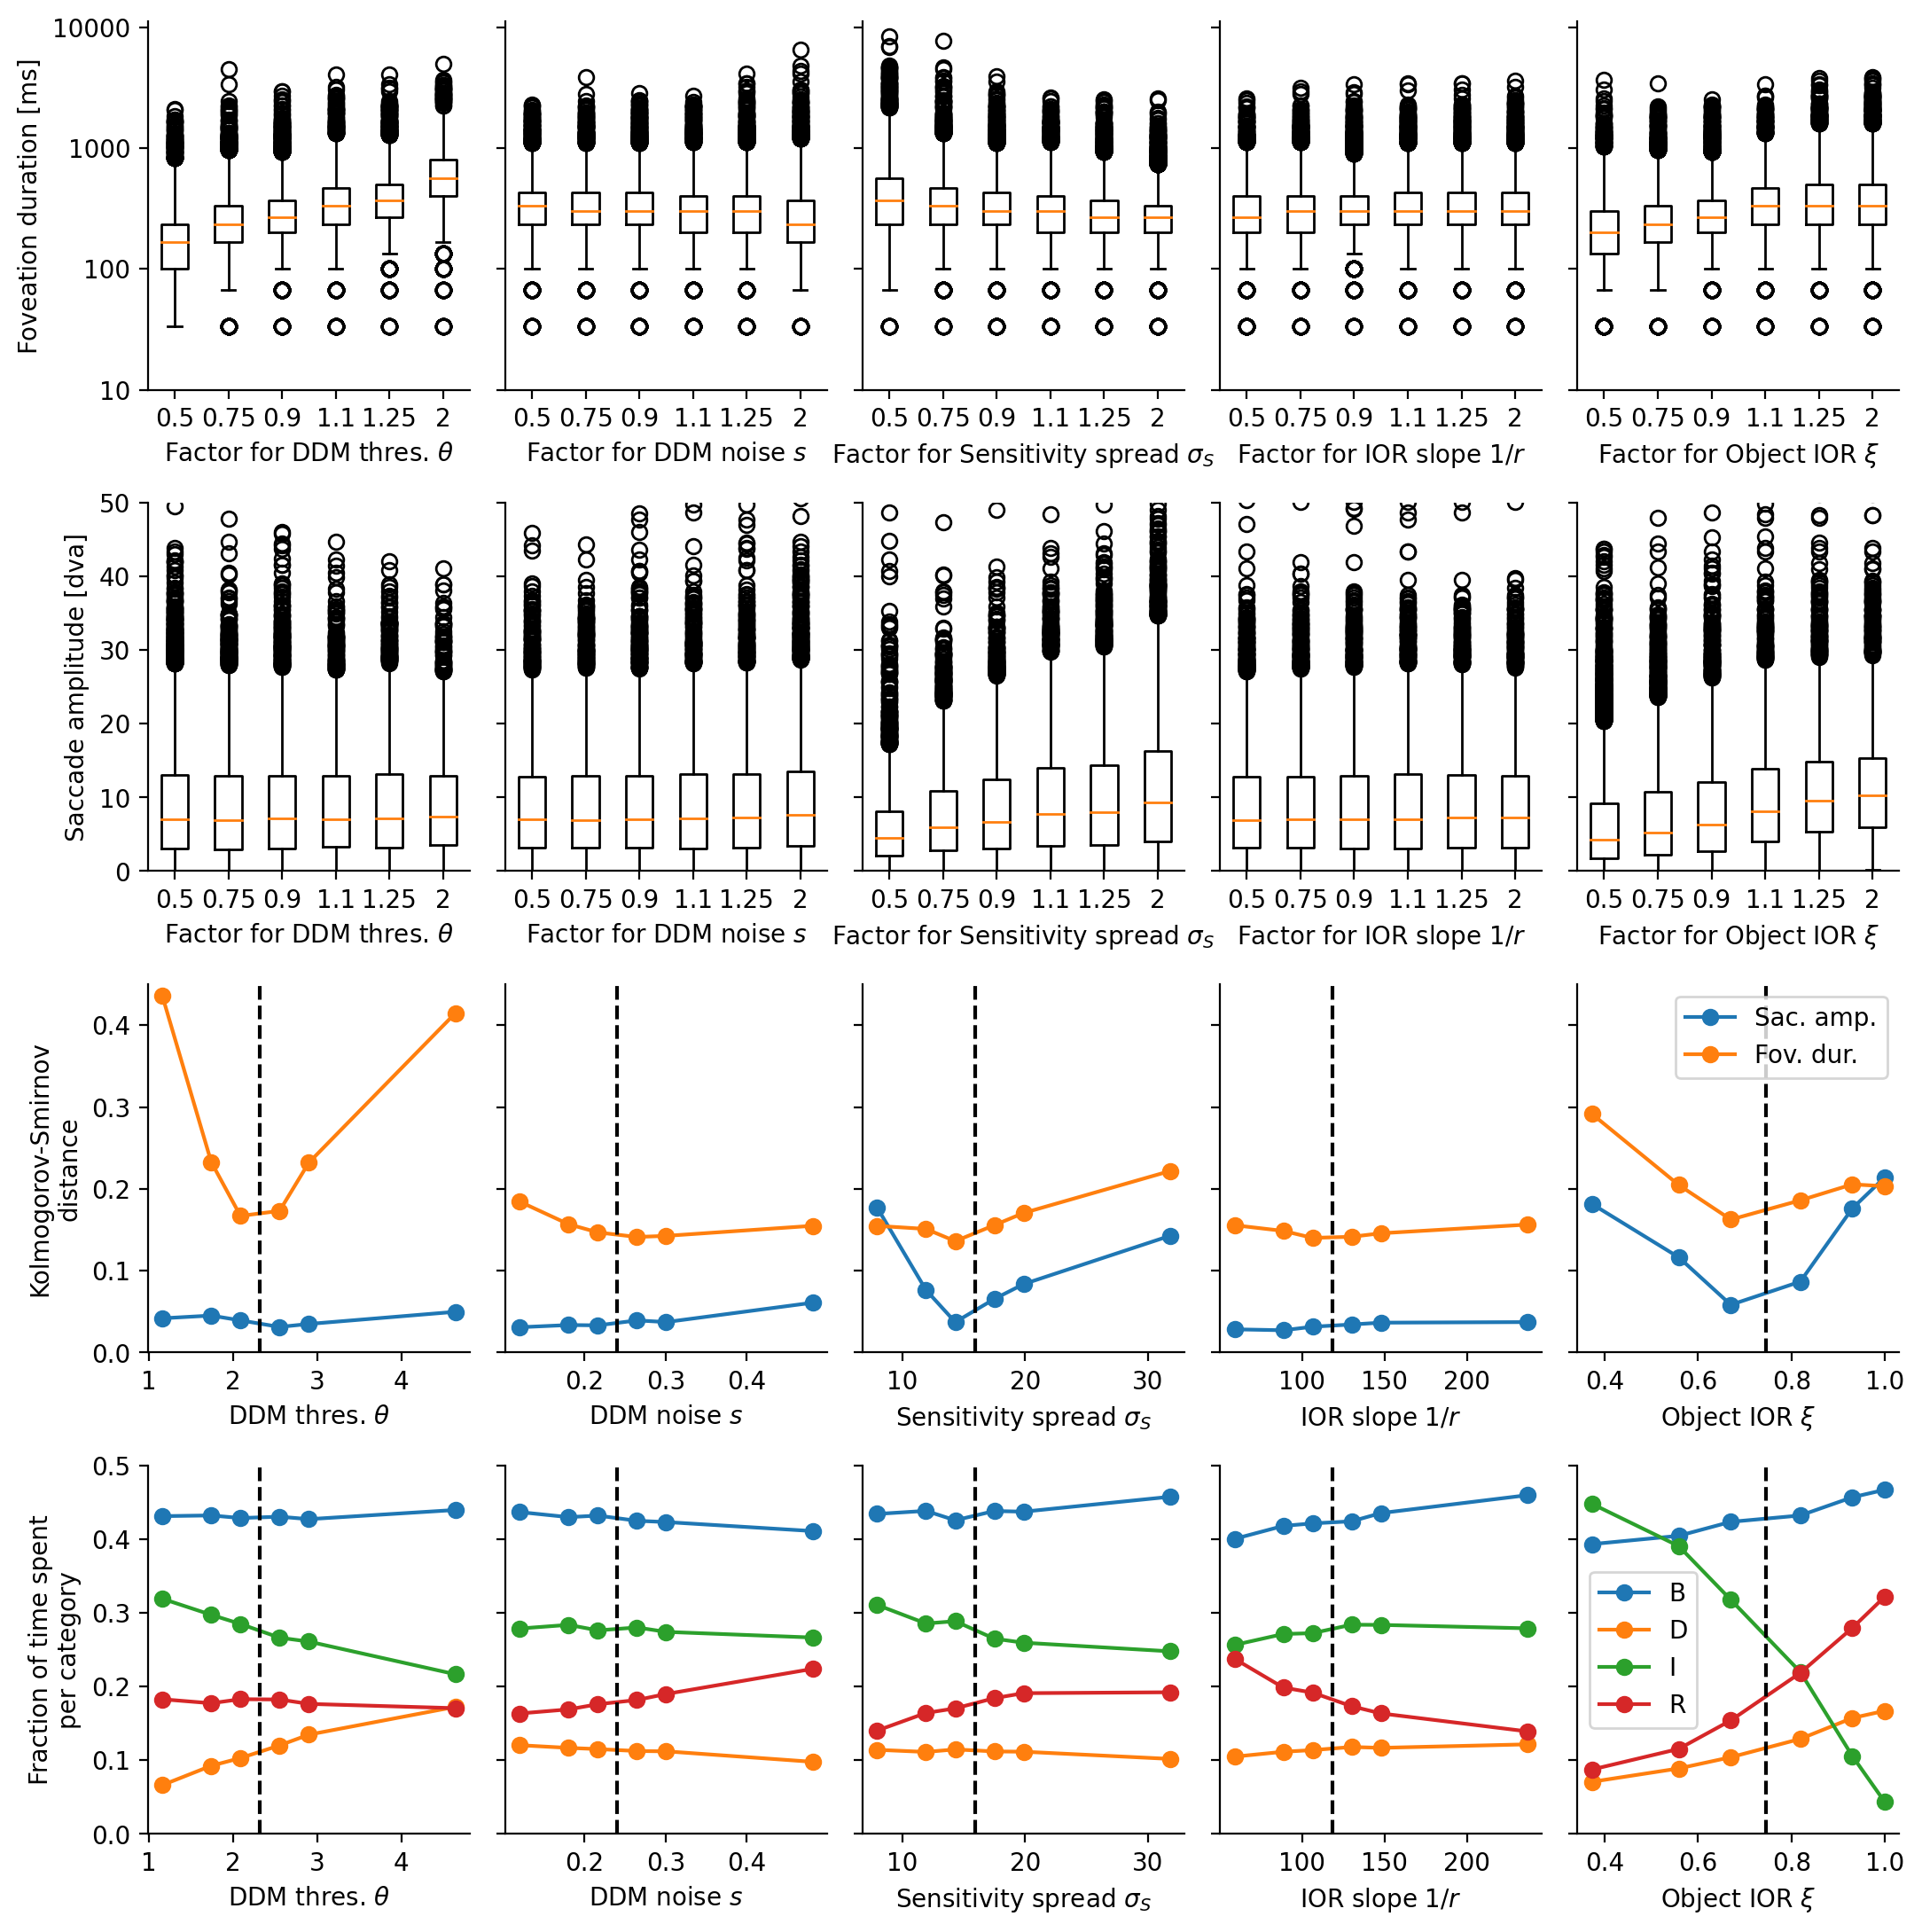

In [34]:
fig, axs = plt.subplots(4, len(parameters), figsize = (11,11), dpi=200, sharey="row")
for p, var_par in enumerate(parameters):
    # initialize lists for each parameter, entries are results for different factors
    dur_data = []
    amp_data = []
    f_amps = []
    f_durs = []
    d_fovcat = {}
    for fovcat in ['B', 'D', 'I', 'R']:
        d_fovcat[fovcat] = []
    # go through factors...
    for f, factor in enumerate(relative_par_vals):
        key = f"{var_par}_{factor}"
        dur_data.append(np.log10(d_res[key]['sim_dur_ms']))
        amp_data.append(d_res[key]['sim_amp_dva'])
        f_amps.append(d_res[key]['ks_amp'])
        f_durs.append(d_res[key]['ks_dur'])
        for i, fovcat in enumerate(['B', 'D', 'I', 'R']):
            d_fovcat[fovcat].append(d_res[key]['fov_cat'][i])

    # plotting, parameters are different colums, rows are metrics
    x_par_vals = mean_pars[var_par] * np.array(relative_par_vals)
    if var_par == 'ior_inobj':
        x_par_vals = np.clip(x_par_vals, 0,1)
    axs[0,p].boxplot(dur_data)#, x='Factor', y='Foveation duration [ms]')
    axs[0,p].set(xticklabels=relative_par_vals, xlabel=f'Factor for {par_sym[p]}', #title=f'{var_par}', 
        yticks=[1, 2, 3, 4], yticklabels=[10, 100, 1000, 10000])
    if p==0:
        axs[0,p].set_ylabel('Foveation duration [ms]')
    axs[1,p].boxplot(amp_data)#, x='Factor', y='Saccade amplitude [dva]')
    axs[1,p].set(xticklabels=relative_par_vals, xlabel=f'Factor for {par_sym[p]}', #title=f'{var_par}', 
        yticks=[0,10,20,30,40,50], ylim=[0,50])
    if p==0:
        axs[1,p].set_ylabel('Saccade amplitude [dva]')
    for fovcat in ['B', 'D', 'I', 'R']:
        axs[3,p].plot(x_par_vals, d_fovcat[fovcat], 'o-', label=fovcat)
    axs[2,p].plot(x_par_vals, f_amps, 'o-', label='Sac. amp.')
    axs[2,p].plot(x_par_vals, f_durs, 'o-', label='Fov. dur.')
    axs[2,p].axvline(mean_pars[var_par], ls='--', color='k')
    if p==4: 
        axs[2,p].legend()
    axs[2,p].set(xlabel=f'{par_sym[p]}', #title=f'{var_par}', 
        ylim=[0,0.45])
    if p==0:
        axs[2,p].set_ylabel('Kolmogorov-Smirnov\ndistance')
    if p==4: 
        axs[3,p].legend()
    axs[3,p].set(xlabel=f'{par_sym[p]}', #title=f'{var_par}', 
        ylim=[0,0.5])
    if p==0:
        axs[3,p].set_ylabel('Fraction of time spent\nper category')
    axs[3,p].axvline(mean_pars[var_par], ls='--', color='k')

plt.tight_layout()
sns.despine(); plt.show()

### Same for location based model... (also old!!!)

In [35]:
# where to get parameters from? --> previous evolution!
runid = 'pxDDM_all_molin_32-32-50_2022-07-08-17H-11M-28S_21087139'

if 'objDDM' in runid:
    model = ObjDDModel(VidCom)
    parameters = ['ddm_thres', 'ddm_sig', 'att_dva', 'ior_decay', 'ior_inobj']
    par_sym = [r'DDM thres. $\theta$', r'DDM noise $s$', r'Sensitivity spread $\sigma_S$', r'IOR slope $1/r$', r'Object IOR $\xi$']
elif 'pxDDM' in runid:
    model = PxlDDModel(VidCom)
    parameters = ['ddm_thres', 'ddm_sig', 'att_dva', 'ior_decay', 'ior_dva']
    par_sym = [r'DDM thres. $\theta$', r'DDM noise $s$', r'Sensitivity spread $\sigma_S$', r'IOR slope $1/r$', r'IOR spread $\sigma_I$']
else:
    raise NotImplementedError("Only Object- and Location-based are implemented")

# load evolution results
DILLNAME = f'{runid}.dill'
evol = Evolution(lambda x: x, ParameterSpace(['mock'], [[0, 1]]))
evol = evol.loadEvolution(f'results/{runid}/{DILLNAME}')
df_evol = evol.dfEvolution(outputs=True).copy()

# Get mean parameters of last generation
df_top32 = df_evol.sort_values('score', ascending=False)[:32]
mean_pars = {}
for par in parameters:
    mean_pars[par] = np.mean(df_top32[par])
print(mean_pars)
    # model.params[par] = df_evol.sort_values('score', ascending=False).iloc[i][par]

# pre computed values for different factors
d_res = {}
relative_par_vals = [0.5, 0.75, 0.9, 1.1, 1.25, 2]
for var_par in parameters:
    for factor in relative_par_vals:
        name = f"res_df_mean_{var_par}_{factor}"
        key = f"{var_par}_{factor}"
        d_res[key] = {}
        # print('%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%\n', name)
        model.result_df = pd.read_csv(f'results/{runid}/{name}.csv')
        # model.show_result_statistics()
        sim_dur_ms = model.result_df["duration_ms"].dropna().values
        sim_amp_dva = model.result_df["sac_amp_dva"].dropna().values
        d_res[key]['sim_dur_ms'] = sim_dur_ms
        d_res[key]['sim_amp_dva'] = sim_amp_dva
        if not sim_amp_dva.size: # if there are no saccades, 
            sim_amp_dva = [0]    # this leads to worst fitness...
        ks_amp, p_amp = stats.ks_2samp(gt_amp_dva, sim_amp_dva)
        ks_dur, p_dur = stats.ks_2samp(gt_dur_ms, sim_dur_ms)
        d_res[key]['ks_amp'] = ks_amp
        d_res[key]['ks_dur'] = ks_dur
        d_res[key]['fov_cat'] = list(model.get_fovcat_ratio().values())

        #df_dict[var_par][str(factor)] = model.result_df


MainProcess root INFO     weightList not set, assuming single fitness value to be maximized.
MainProcess root INFO     Trajectory Name: results-2023-03-02-16H-58M-32S
MainProcess root INFO     Storing data to: ./data/hdf/evolution.hdf
MainProcess root INFO     Trajectory Name: results-2023-03-02-16H-58M-32S
MainProcess root INFO     Number of cores: 40
MainProcess pypet.storageservice.HDF5StorageService INFO     I will use the hdf5 file `./data/hdf/evolution.hdf`.
MainProcess pypet.environment.Environment INFO     Environment initialized.
MainProcess root INFO     Evolution: Using algorithm: adaptive
/home/users/n/nicolas-roth/miniconda3/envs/venv/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMulti' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/users/n/nicolas-roth/miniconda3/envs/venv/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A 

{'ddm_thres': 0.3652492398675593, 'ddm_sig': 0.011361307036757104, 'att_dva': 12.175852649569059, 'ior_decay': 270.4708955749298, 'ior_dva': 6.481256992702386}


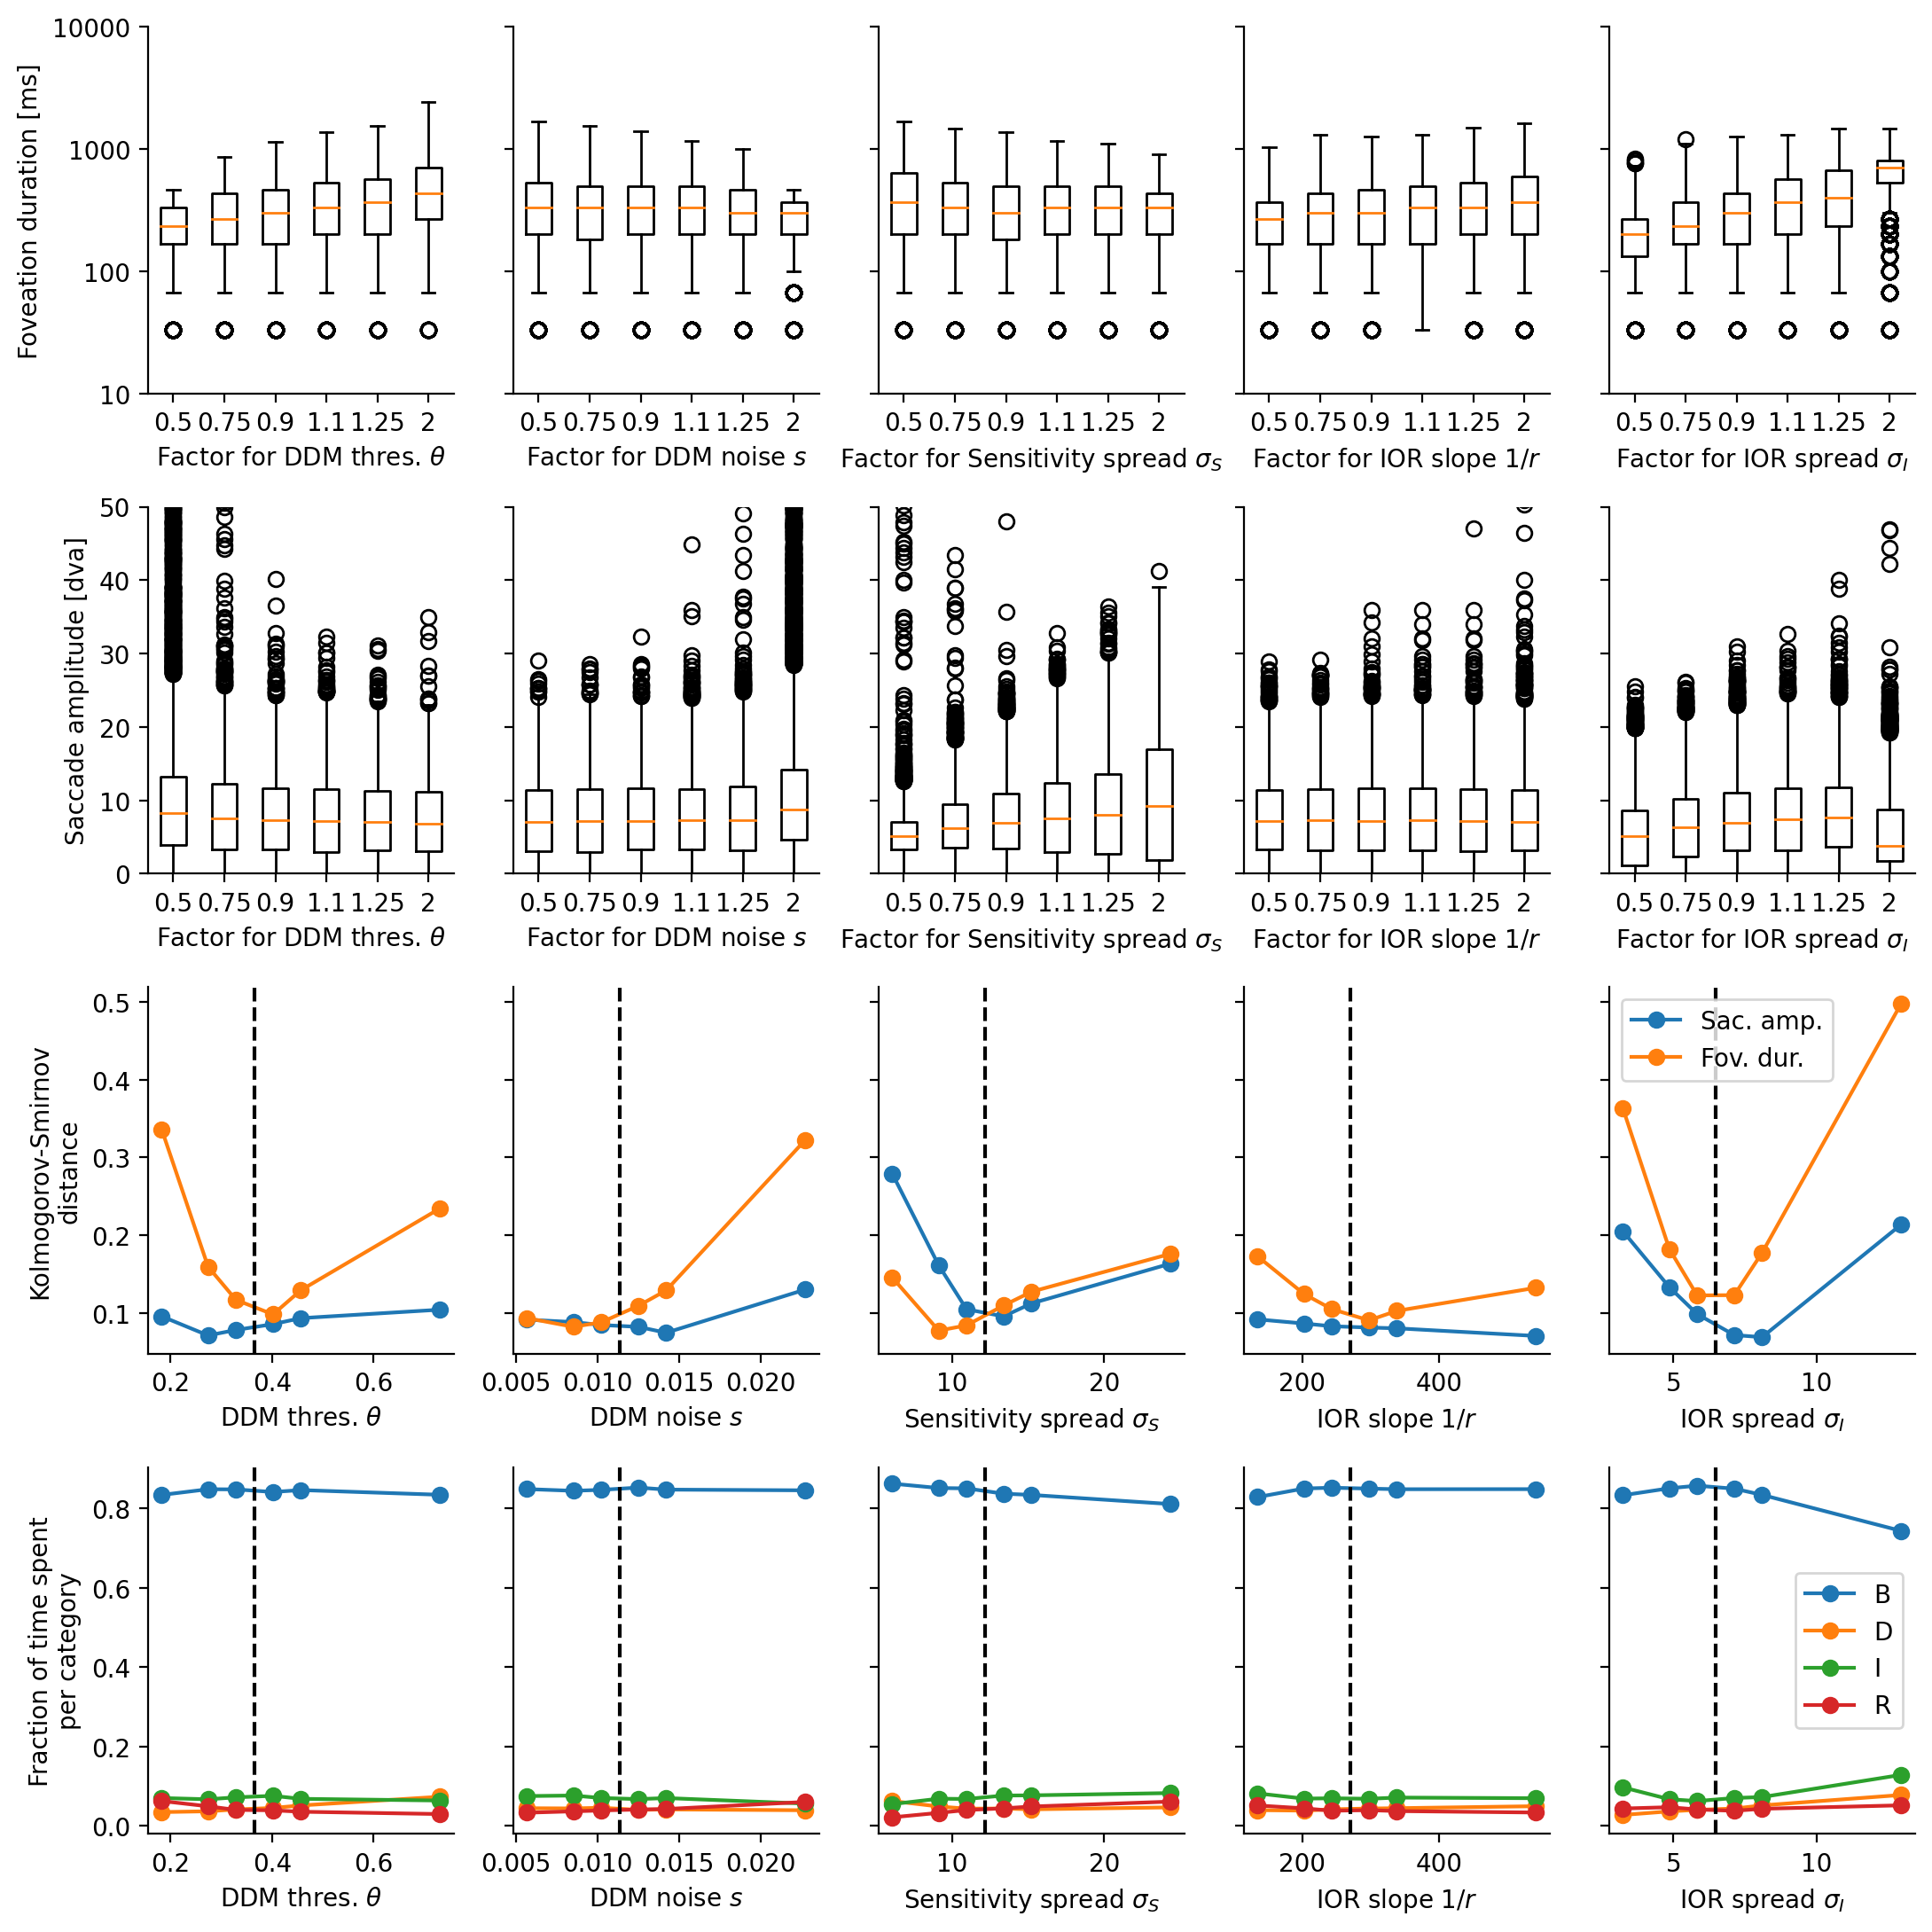

In [37]:
fig, axs = plt.subplots(4, len(parameters), figsize = (11,11), dpi=200, sharey="row")
for p, var_par in enumerate(parameters):
    # initialize lists for each parameter, entries are results for different factors
    dur_data = []
    amp_data = []
    f_amps = []
    f_durs = []
    d_fovcat = {}
    for fovcat in ['B', 'D', 'I', 'R']:
        d_fovcat[fovcat] = []
    # go through factors...
    for f, factor in enumerate(relative_par_vals):
        key = f"{var_par}_{factor}"
        dur_data.append(np.log10(d_res[key]['sim_dur_ms']))
        amp_data.append(d_res[key]['sim_amp_dva'])
        f_amps.append(d_res[key]['ks_amp'])
        f_durs.append(d_res[key]['ks_dur'])
        for i, fovcat in enumerate(['B', 'D', 'I', 'R']):
            d_fovcat[fovcat].append(d_res[key]['fov_cat'][i])

    # plotting, parameters are different colums, rows are metrics
    x_par_vals = mean_pars[var_par] * np.array(relative_par_vals)
    if var_par == 'ior_inobj':
        x_par_vals = np.clip(x_par_vals, 0,1)
    axs[0,p].boxplot(dur_data)#, x='Factor', y='Foveation duration [ms]')
    axs[0,p].set(xticklabels=relative_par_vals, xlabel=f'Factor for {par_sym[p]}', #title=f'{var_par}', 
        yticks=[1, 2, 3, 4], yticklabels=[10, 100, 1000, 10000])
    if p==0:
        axs[0,p].set_ylabel('Foveation duration [ms]')
    axs[1,p].boxplot(amp_data)#, x='Factor', y='Saccade amplitude [dva]')
    axs[1,p].set(xticklabels=relative_par_vals, xlabel=f'Factor for {par_sym[p]}', #title=f'{var_par}', 
        yticks=[0,10,20,30,40,50], ylim=[0,50])
    if p==0:
        axs[1,p].set_ylabel('Saccade amplitude [dva]')
    for fovcat in ['B', 'D', 'I', 'R']:
        axs[3,p].plot(x_par_vals, d_fovcat[fovcat], 'o-', label=fovcat)
    axs[2,p].plot(x_par_vals, f_amps, 'o-', label='Sac. amp.')
    axs[2,p].plot(x_par_vals, f_durs, 'o-', label='Fov. dur.')
    axs[2,p].axvline(mean_pars[var_par], ls='--', color='k')
    if p==4: 
        axs[2,p].legend()
    axs[2,p].set(xlabel=f'{par_sym[p]}')#, #title=f'{var_par}',ylim=[0,0.45])
    if p==0:
        axs[2,p].set_ylabel('Kolmogorov-Smirnov\ndistance')
    if p==4: 
        axs[3,p].legend()
    axs[3,p].set(xlabel=f'{par_sym[p]}')#, #title=f'{var_par}',ylim=[0,0.5])
    if p==0:
        axs[3,p].set_ylabel('Fraction of time spent\nper category')
    axs[3,p].axvline(mean_pars[var_par], ls='--', color='k')

plt.tight_layout()
sns.despine(); plt.show()

## S3-6: Parameter spaces of the 4 models

MainProcess root INFO     weightList not set, assuming single fitness value to be maximized.
MainProcess root INFO     Trajectory Name: results-2022-12-23-11H-43M-48S
MainProcess root INFO     Storing data to: ./data/hdf/evolution.hdf
MainProcess root INFO     Trajectory Name: results-2022-12-23-11H-43M-48S
MainProcess root INFO     Number of cores: 40
MainProcess pypet.storageservice.HDF5StorageService INFO     I will use the hdf5 file `./data/hdf/evolution.hdf`.
MainProcess pypet.environment.Environment INFO     Environment initialized.
MainProcess root INFO     Evolution: Using algorithm: adaptive
/home/users/n/nicolas-roth/miniconda3/envs/venv/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMulti' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/users/n/nicolas-roth/miniconda3/envs/venv/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A 

> Simulation parameters
HDF file storage: ./data/hdf/pxDDM_train_molin_64-32-50_2022-12-14-02H-35M-35S_22026683.hdf
Trajectory Name: results-2022-12-14-02H-35M-35S
Duration of evaluating initial population 1:00:31.127572
Duration of evolution 1 day, 1:04:21.745582
Eval function: <function optimize_me at 0x7f69bf653b90>
Parameter space: {'ddm_thres': [0.2, 2], 'ddm_sig': [0.01, 0.1], 'att_dva': [3, 15], 'ior_decay': [30, 300], 'ior_dva': [0.5, 10]}
> Evolution parameters
Number of generations: 50
Initial population size: 64
Population size: 32
> Evolutionary operators
Mating operator: <function cxBlend at 0x7f69d0c75320>
Mating paramter: {'alpha': 0.5}
Selection operator: <function selBest_multiObj at 0x7f69ccb50cb0>
Selection paramter: {}
Parent selection operator: <function selRank at 0x7f69ccb50c20>
Comments: no comments
--- Info summary ---
Valid: 32
Mean score (weighted fitness): -0.1
Parameter distribution (Generation 49):
ddm_thres: 	 mean: 0.3965,	 std: 0.0402
ddm_sig: 	 mean: 0

/home/users/n/nicolas-roth/miniconda3/envs/venv/lib/python3.7/site-packages/neurolib/optimize/evolution/evolutionaryUtils.py:212: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


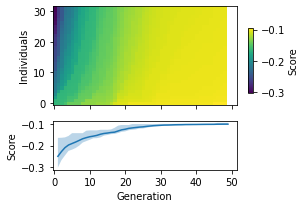

MainProcess root INFO     Saving plot to ./data/figures/results-2022-12-14-02H-35M-35S_hist_49.png


There are 32 valid individuals
Mean score across population: -0.1


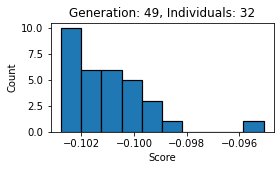

<Figure size 432x288 with 0 Axes>

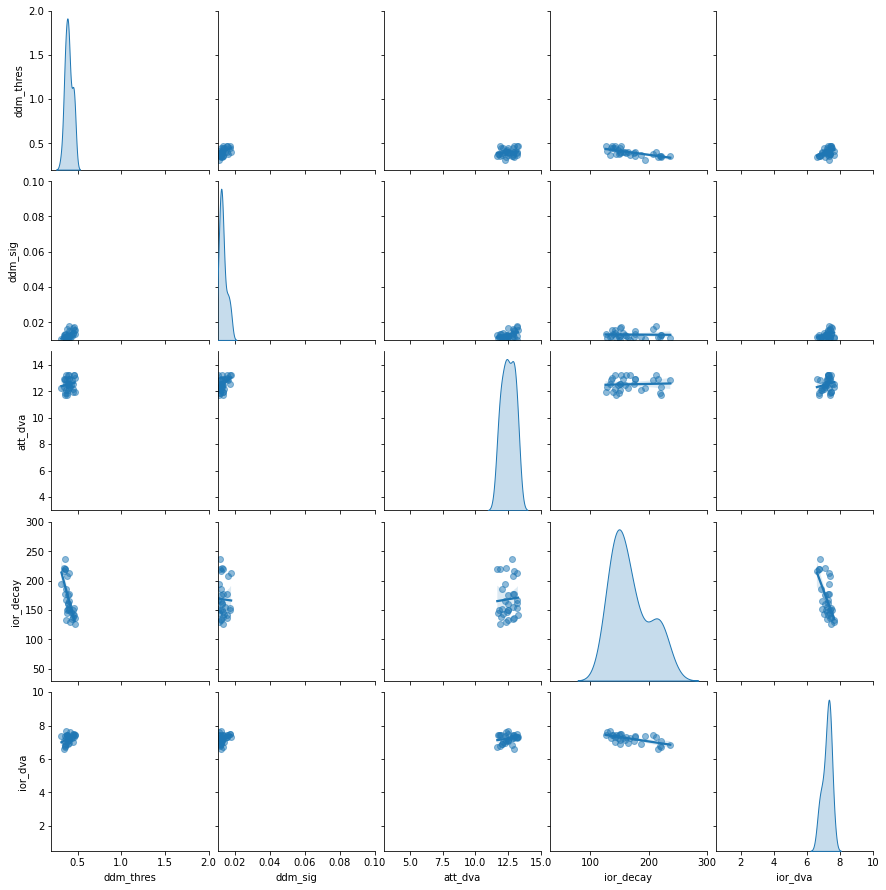

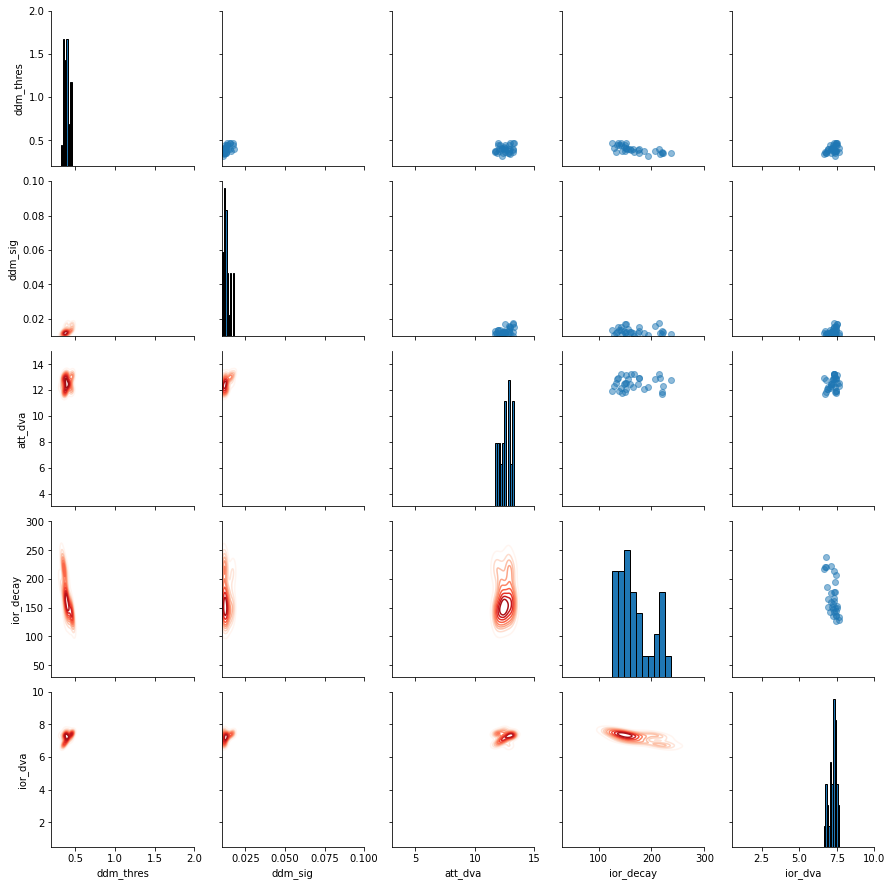

MainProcess root INFO     weightList not set, assuming single fitness value to be maximized.
MainProcess root INFO     Trajectory Name: results-2022-12-23-11H-44M-10S
MainProcess root INFO     Storing data to: ./data/hdf/evolution.hdf
MainProcess root INFO     Trajectory Name: results-2022-12-23-11H-44M-10S
MainProcess root INFO     Number of cores: 40
MainProcess pypet.storageservice.HDF5StorageService INFO     I will use the hdf5 file `./data/hdf/evolution.hdf`.
MainProcess pypet.environment.Environment INFO     Environment initialized.
MainProcess root INFO     Evolution: Using algorithm: adaptive
/home/users/n/nicolas-roth/miniconda3/envs/venv/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMulti' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/users/n/nicolas-roth/miniconda3/envs/venv/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A 

> Simulation parameters
HDF file storage: ./data/hdf/pxDDM_train_TASEDnet_64-32-50_2022-12-14-02H-34M-38S_22026682.hdf
Trajectory Name: results-2022-12-14-02H-34M-38S
Duration of evaluating initial population 1:10:27.615060
Duration of evolution 1 day, 0:41:31.078623
Eval function: <function optimize_me at 0x7f69c9b5b170>
Parameter space: {'ddm_thres': [0.2, 2], 'ddm_sig': [0.01, 0.1], 'att_dva': [3, 15], 'ior_decay': [30, 300], 'ior_dva': [0.5, 10]}
> Evolution parameters
Number of generations: 50
Initial population size: 64
Population size: 32
> Evolutionary operators
Mating operator: <function cxBlend at 0x7f69d0c75320>
Mating paramter: {'alpha': 0.5}
Selection operator: <function selBest_multiObj at 0x7f69ccb50cb0>
Selection paramter: {}
Parent selection operator: <function selRank at 0x7f69ccb50c20>
Comments: no comments
--- Info summary ---
Valid: 32
Mean score (weighted fitness): -0.14
Parameter distribution (Generation 49):
ddm_thres: 	 mean: 1.5835,	 std: 0.0743
ddm_sig: 	 mea

/home/users/n/nicolas-roth/miniconda3/envs/venv/lib/python3.7/site-packages/neurolib/optimize/evolution/evolutionaryUtils.py:212: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


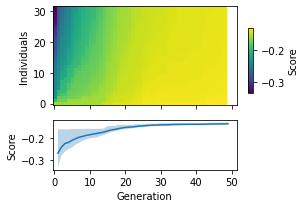

MainProcess root INFO     Saving plot to ./data/figures/results-2022-12-14-02H-34M-38S_hist_49.png


There are 32 valid individuals
Mean score across population: -0.14


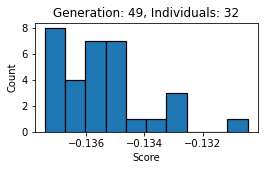

<Figure size 432x288 with 0 Axes>

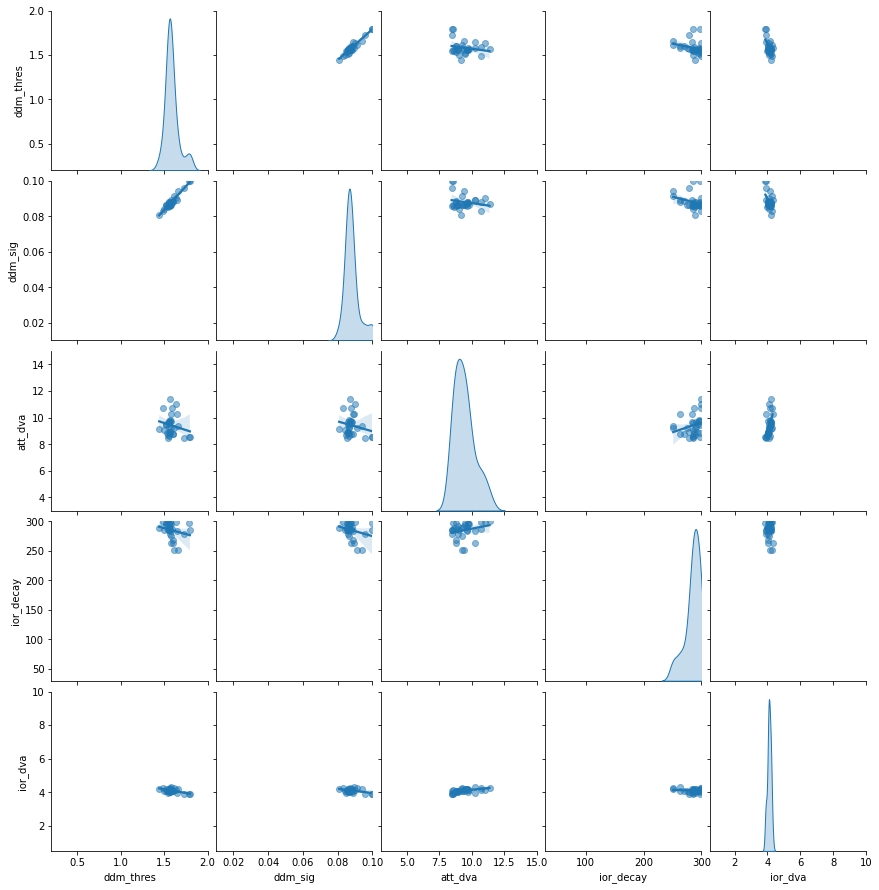

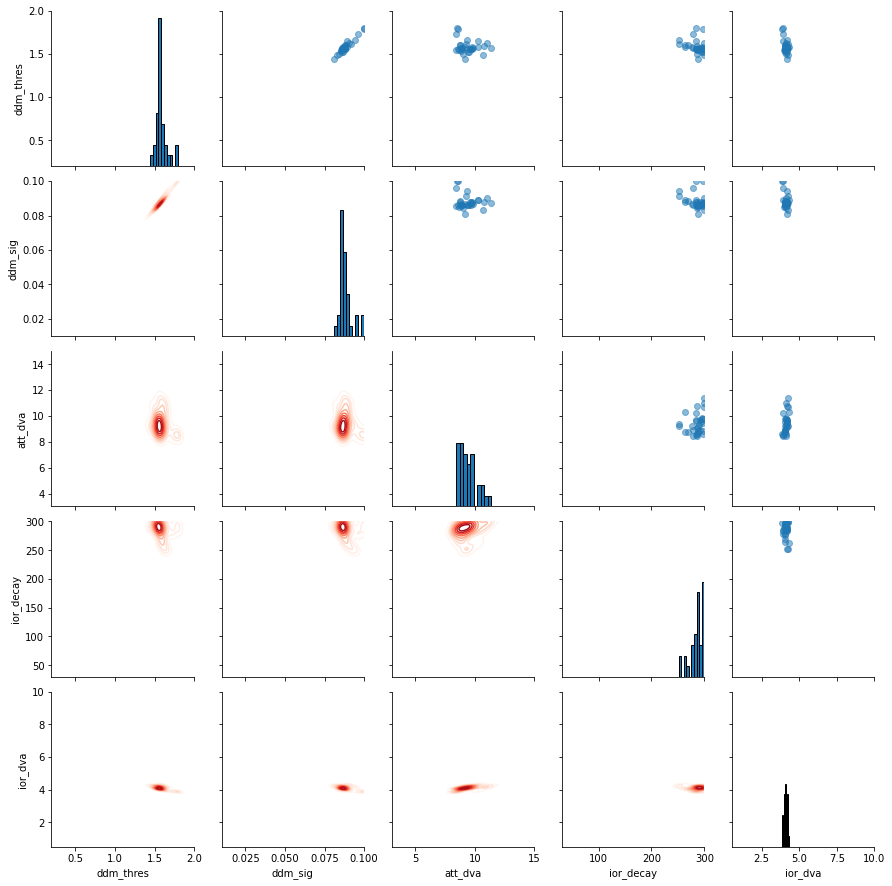

MainProcess root INFO     weightList not set, assuming single fitness value to be maximized.
MainProcess root INFO     Trajectory Name: results-2022-12-23-11H-44M-30S
MainProcess root INFO     Storing data to: ./data/hdf/evolution.hdf
MainProcess root INFO     Trajectory Name: results-2022-12-23-11H-44M-30S
MainProcess root INFO     Number of cores: 40
MainProcess pypet.storageservice.HDF5StorageService INFO     I will use the hdf5 file `./data/hdf/evolution.hdf`.
MainProcess pypet.environment.Environment INFO     Environment initialized.
MainProcess root INFO     Evolution: Using algorithm: adaptive
/home/users/n/nicolas-roth/miniconda3/envs/venv/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMulti' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/users/n/nicolas-roth/miniconda3/envs/venv/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A 

> Simulation parameters
HDF file storage: ./data/hdf/objDDM_train_molin_64-32-50_2022-12-14-02H-36M-30S_22026684.hdf
Trajectory Name: results-2022-12-14-02H-36M-30S
Duration of evaluating initial population 0:41:06.515915
Duration of evolution 17:12:46.671201
Eval function: <function optimize_me at 0x7f69ca0bfcb0>
Parameter space: {'ddm_thres': [1.0, 3.0], 'ddm_sig': [0.05, 0.25], 'att_dva': [5, 20], 'ior_decay': [30, 300], 'ior_inobj': [0.4, 1.0]}
> Evolution parameters
Number of generations: 50
Initial population size: 64
Population size: 32
> Evolutionary operators
Mating operator: <function cxBlend at 0x7f69d0c75320>
Mating paramter: {'alpha': 0.5}
Selection operator: <function selBest_multiObj at 0x7f69ccb50cb0>
Selection paramter: {}
Parent selection operator: <function selRank at 0x7f69ccb50c20>
Comments: no comments
--- Info summary ---
Valid: 32
Mean score (weighted fitness): -0.089
Parameter distribution (Generation 49):
ddm_thres: 	 mean: 1.8091,	 std: 0.0643
ddm_sig: 	 mean

/home/users/n/nicolas-roth/miniconda3/envs/venv/lib/python3.7/site-packages/neurolib/optimize/evolution/evolutionaryUtils.py:212: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


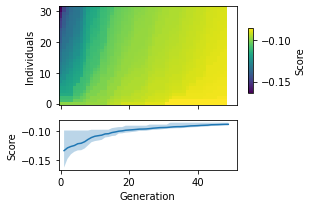

MainProcess root INFO     Saving plot to ./data/figures/results-2022-12-14-02H-36M-30S_hist_49.png


There are 32 valid individuals
Mean score across population: -0.089


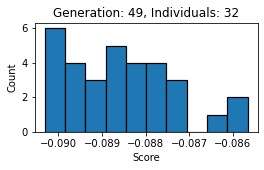

<Figure size 432x288 with 0 Axes>

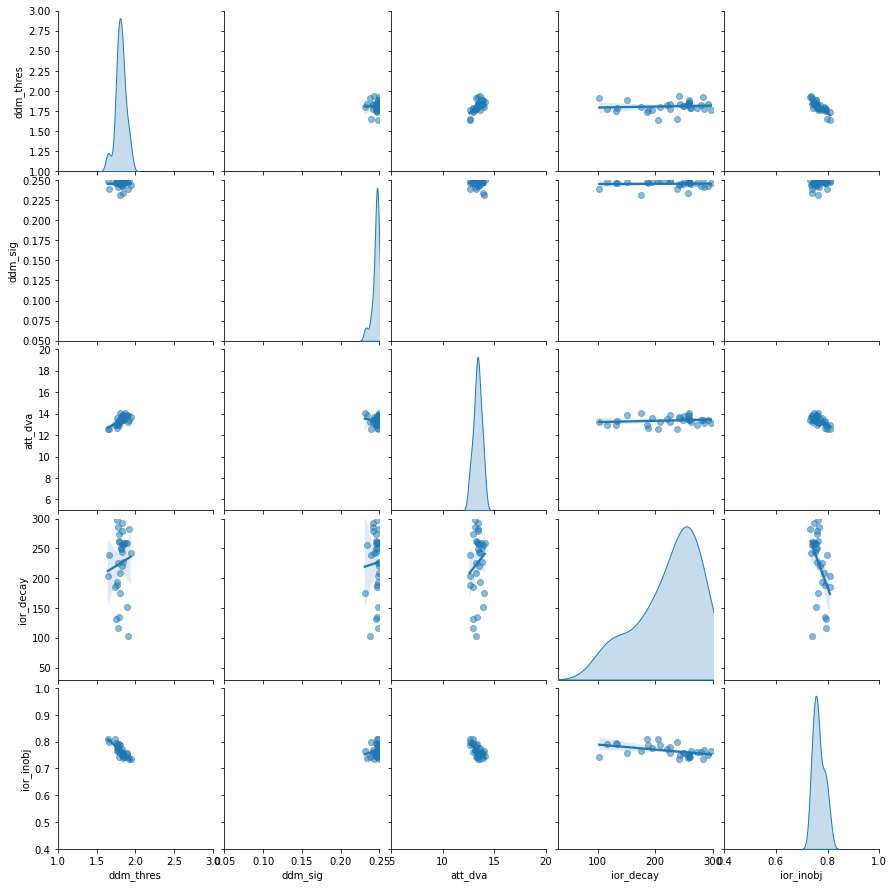

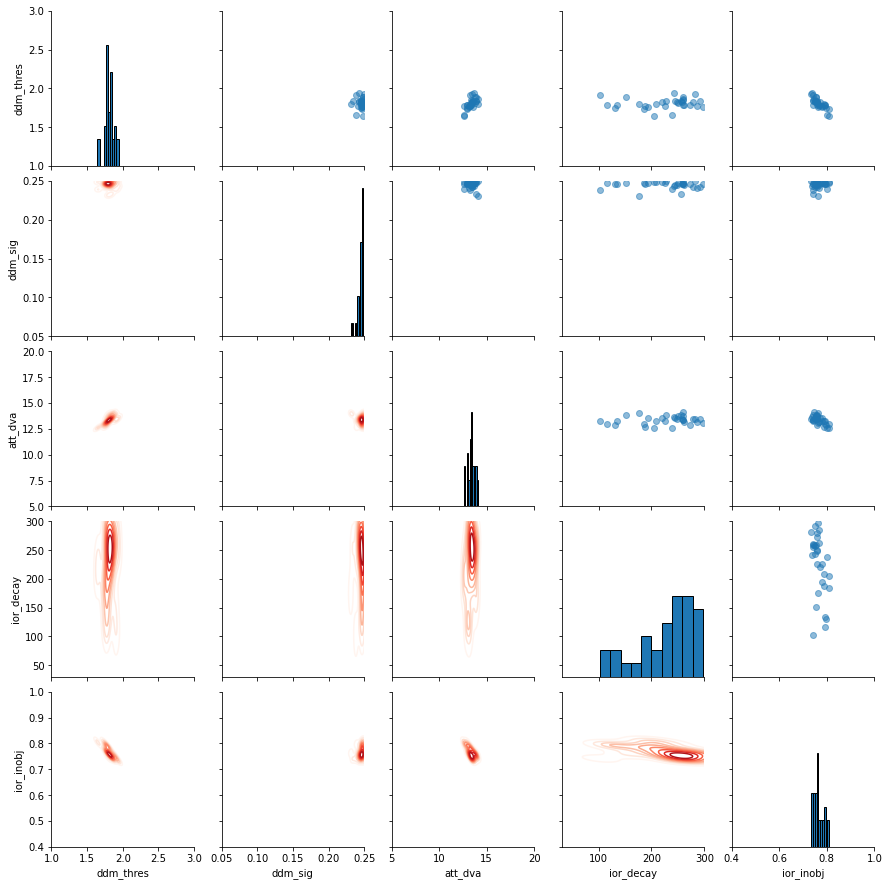

MainProcess root INFO     weightList not set, assuming single fitness value to be maximized.
MainProcess root INFO     Trajectory Name: results-2022-12-23-11H-44M-52S
MainProcess root INFO     Storing data to: ./data/hdf/evolution.hdf
MainProcess root INFO     Trajectory Name: results-2022-12-23-11H-44M-52S
MainProcess root INFO     Number of cores: 40
MainProcess pypet.storageservice.HDF5StorageService INFO     I will use the hdf5 file `./data/hdf/evolution.hdf`.
MainProcess pypet.environment.Environment INFO     Environment initialized.
MainProcess root INFO     Evolution: Using algorithm: adaptive
/home/users/n/nicolas-roth/miniconda3/envs/venv/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMulti' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/users/n/nicolas-roth/miniconda3/envs/venv/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A 

> Simulation parameters
HDF file storage: ./data/hdf/objDDM_train_None_64-32-50_2022-12-14-02H-37M-32S_22026685.hdf
Trajectory Name: results-2022-12-14-02H-37M-32S
Duration of evaluating initial population 0:44:27.436187
Duration of evolution 17:00:04.141274
Eval function: <function optimize_me at 0x7f69ca00f050>
Parameter space: {'ddm_thres': [1.0, 3.0], 'ddm_sig': [0.05, 0.25], 'att_dva': [5, 20], 'ior_decay': [30, 300], 'ior_inobj': [0.4, 1.0]}
> Evolution parameters
Number of generations: 50
Initial population size: 64
Population size: 32
> Evolutionary operators
Mating operator: <function cxBlend at 0x7f69d0c75320>
Mating paramter: {'alpha': 0.5}
Selection operator: <function selBest_multiObj at 0x7f69ccb50cb0>
Selection paramter: {}
Parent selection operator: <function selRank at 0x7f69ccb50c20>
Comments: no comments
--- Info summary ---
Valid: 32
Mean score (weighted fitness): -0.16
Parameter distribution (Generation 49):
ddm_thres: 	 mean: 2.9037,	 std: 0.0584
ddm_sig: 	 mean: 

/home/users/n/nicolas-roth/miniconda3/envs/venv/lib/python3.7/site-packages/neurolib/optimize/evolution/evolutionaryUtils.py:212: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


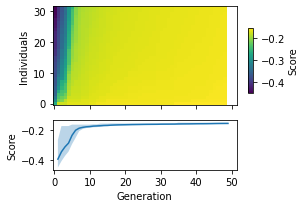

MainProcess root INFO     Saving plot to ./data/figures/results-2022-12-14-02H-37M-32S_hist_49.png


There are 32 valid individuals
Mean score across population: -0.16


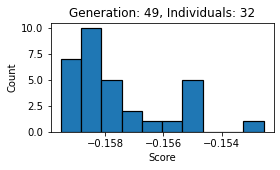

<Figure size 432x288 with 0 Axes>

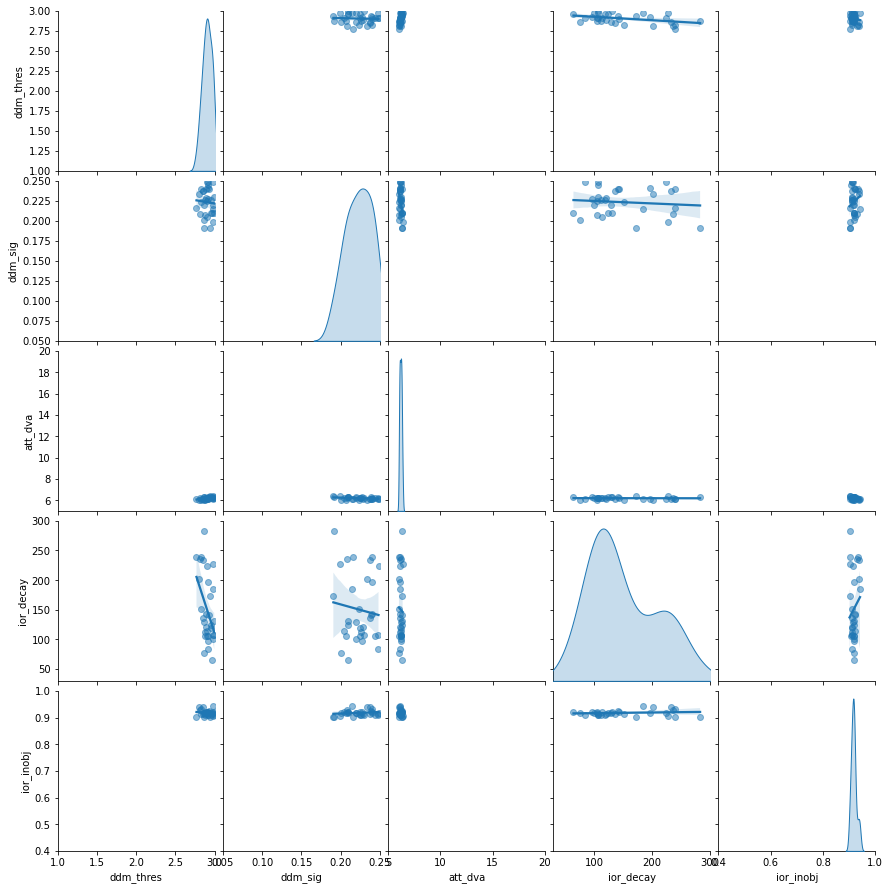

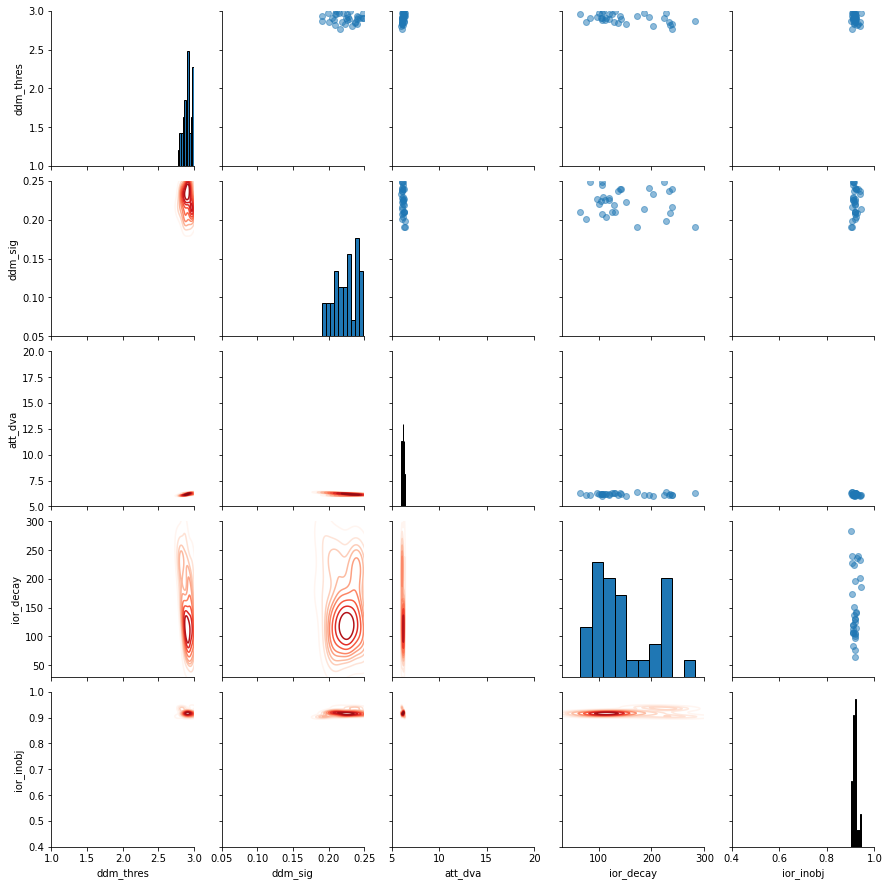

In [15]:
run_ids = [
    'pxDDM_train_molin_64-32-50_2022-12-14-02H-35M-35S_22026683',
    'pxDDM_train_TASEDnet_64-32-50_2022-12-14-02H-34M-38S_22026682',
    'objDDM_train_molin_64-32-50_2022-12-14-02H-36M-30S_22026684',
    'objDDM_train_None_64-32-50_2022-12-14-02H-37M-32S_22026685',
]
for runid in run_ids:
    DILLNAME = f'{runid}.dill'
    evol = Evolution(lambda x: x, ParameterSpace(['mock'], [[0, 1]]))
    evol = evol.loadEvolution(f'results/{runid}/{DILLNAME}')
    evol.info()


### S7 see above

### S8-11: fit with 3 objectives

MainProcess root INFO     weightList not set, assuming single fitness value to be maximized.
MainProcess root INFO     Trajectory Name: results-2022-12-23-11H-45M-18S
MainProcess root INFO     Storing data to: ./data/hdf/evolution.hdf
MainProcess root INFO     Trajectory Name: results-2022-12-23-11H-45M-18S
MainProcess root INFO     Number of cores: 40
MainProcess pypet.storageservice.HDF5StorageService INFO     I will use the hdf5 file `./data/hdf/evolution.hdf`.
MainProcess pypet.environment.Environment INFO     Environment initialized.
MainProcess root INFO     Evolution: Using algorithm: adaptive
/home/users/n/nicolas-roth/miniconda3/envs/venv/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMulti' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/users/n/nicolas-roth/miniconda3/envs/venv/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A 

> Simulation parameters
HDF file storage: ./data/hdf/pxDDM_train_molin_wFovCat_64-32-50_2022-12-15-17H-06M-38S_22029113.hdf
Trajectory Name: results-2022-12-15-17H-06M-38S
Duration of evaluating initial population 1:04:46.383254
Duration of evolution 1 day, 1:07:13.548299
Eval function: <function optimize_me at 0x7f69c8e44290>
Parameter space: {'ddm_thres': [0.2, 2], 'ddm_sig': [0.01, 0.1], 'att_dva': [3, 15], 'ior_decay': [30, 300], 'ior_dva': [0.5, 10]}
> Evolution parameters
Number of generations: 50
Initial population size: 64
Population size: 32
> Evolutionary operators
Mating operator: <function cxBlend at 0x7f69d0c75320>
Mating paramter: {'alpha': 0.5}
Selection operator: <function selBest_multiObj at 0x7f69ccb50cb0>
Selection paramter: {}
Parent selection operator: <function selRank at 0x7f69ccb50c20>
Comments: no comments
--- Info summary ---
Valid: 32
Mean score (weighted fitness): -0.32
Parameter distribution (Generation 49):
ddm_thres: 	 mean: 0.3922,	 std: 0.0817
ddm_sig: 

/home/users/n/nicolas-roth/miniconda3/envs/venv/lib/python3.7/site-packages/neurolib/optimize/evolution/evolutionaryUtils.py:212: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


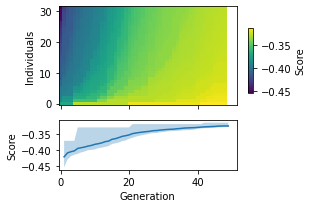

MainProcess root INFO     Saving plot to ./data/figures/results-2022-12-15-17H-06M-38S_hist_49.png


There are 32 valid individuals
Mean score across population: -0.32


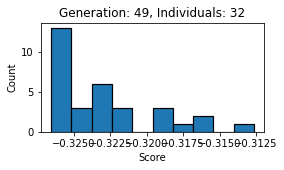

<Figure size 432x288 with 0 Axes>

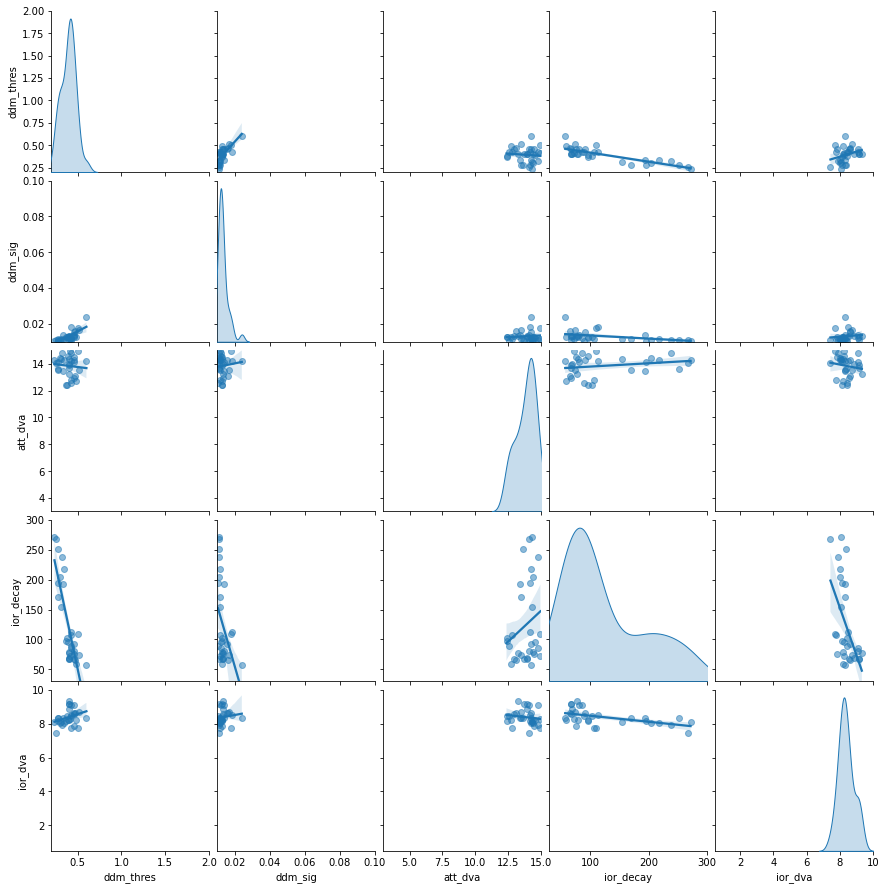

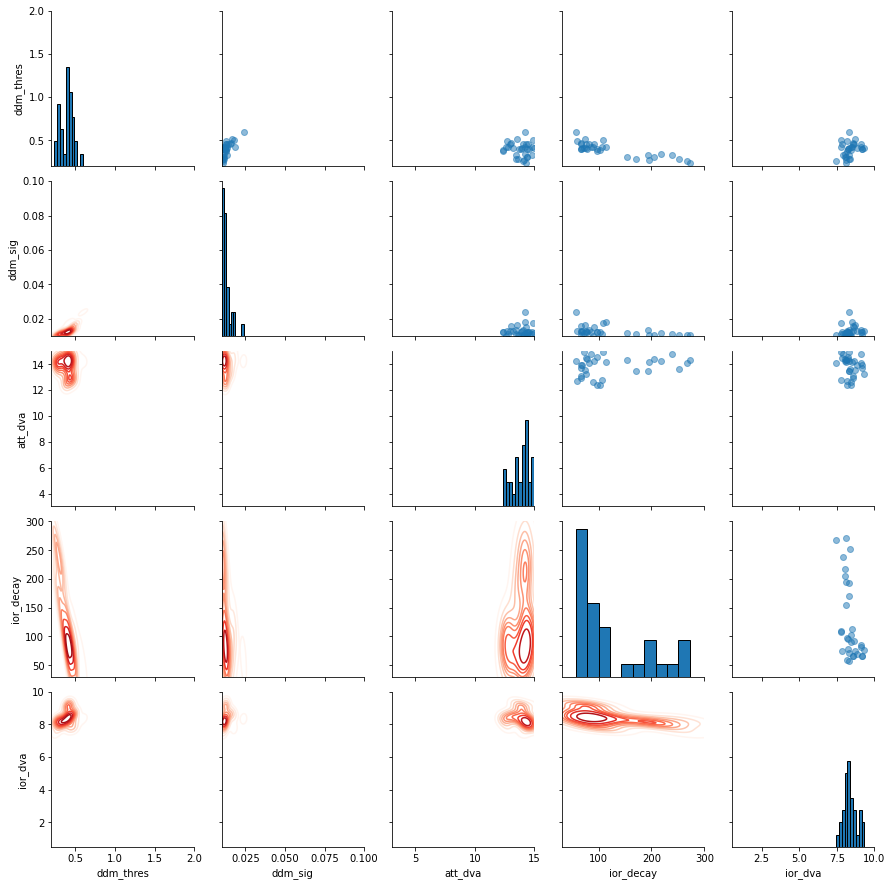

MainProcess root INFO     weightList not set, assuming single fitness value to be maximized.
MainProcess root INFO     Trajectory Name: results-2022-12-23-11H-45M-38S
MainProcess root INFO     Storing data to: ./data/hdf/evolution.hdf
MainProcess root INFO     Trajectory Name: results-2022-12-23-11H-45M-38S
MainProcess root INFO     Number of cores: 40
MainProcess pypet.storageservice.HDF5StorageService INFO     I will use the hdf5 file `./data/hdf/evolution.hdf`.
MainProcess pypet.environment.Environment INFO     Environment initialized.
MainProcess root INFO     Evolution: Using algorithm: adaptive
/home/users/n/nicolas-roth/miniconda3/envs/venv/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMulti' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/users/n/nicolas-roth/miniconda3/envs/venv/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A 

> Simulation parameters
HDF file storage: ./data/hdf/pxDDM_train_TASEDnet_wFovCat_64-32-50_2022-12-15-17H-07M-00S_22029114.hdf
Trajectory Name: results-2022-12-15-17H-07M-00S
Duration of evaluating initial population 1:05:40.976637
Duration of evolution 1 day, 1:37:34.389343
Eval function: <function optimize_me at 0x7f69c8c6e200>
Parameter space: {'ddm_thres': [0.2, 2], 'ddm_sig': [0.01, 0.1], 'att_dva': [3, 15], 'ior_decay': [30, 300], 'ior_dva': [0.5, 10]}
> Evolution parameters
Number of generations: 50
Initial population size: 64
Population size: 32
> Evolutionary operators
Mating operator: <function cxBlend at 0x7f69d0c75320>
Mating paramter: {'alpha': 0.5}
Selection operator: <function selBest_multiObj at 0x7f69ccb50cb0>
Selection paramter: {}
Parent selection operator: <function selRank at 0x7f69ccb50c20>
Comments: no comments
--- Info summary ---
Valid: 32
Mean score (weighted fitness): -0.22
Parameter distribution (Generation 49):
ddm_thres: 	 mean: 1.4738,	 std: 0.1256
ddm_si

/home/users/n/nicolas-roth/miniconda3/envs/venv/lib/python3.7/site-packages/neurolib/optimize/evolution/evolutionaryUtils.py:212: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


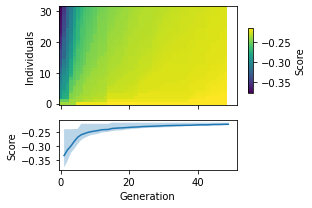

MainProcess root INFO     Saving plot to ./data/figures/results-2022-12-15-17H-07M-00S_hist_49.png


There are 32 valid individuals
Mean score across population: -0.22


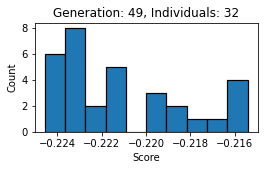

<Figure size 432x288 with 0 Axes>

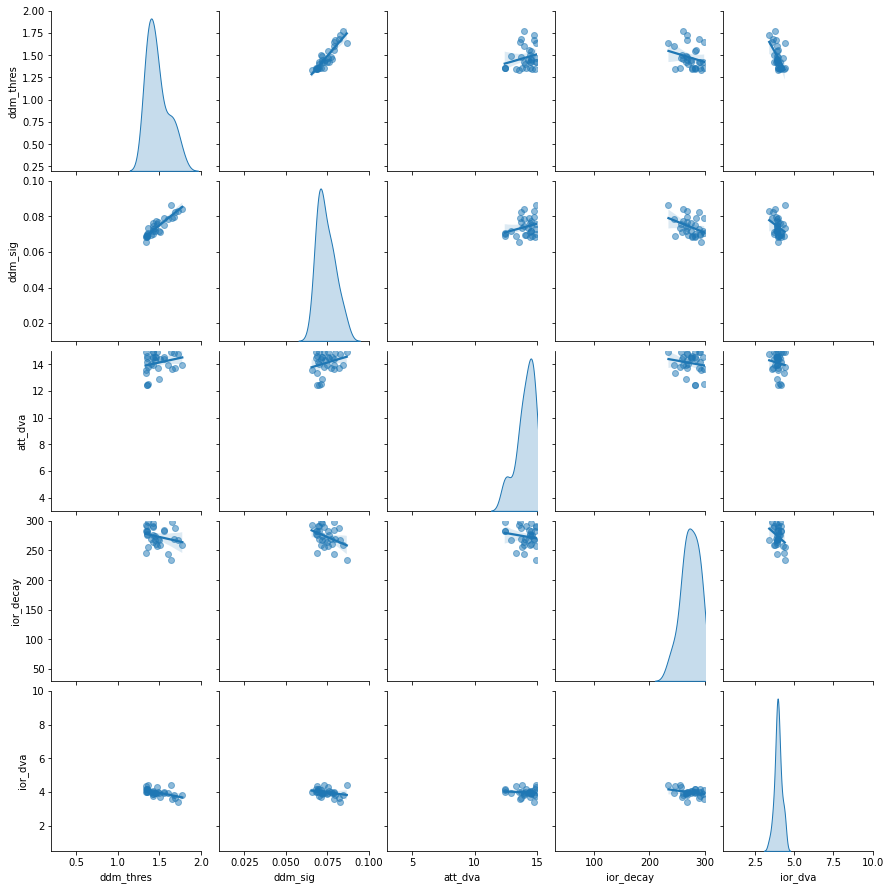

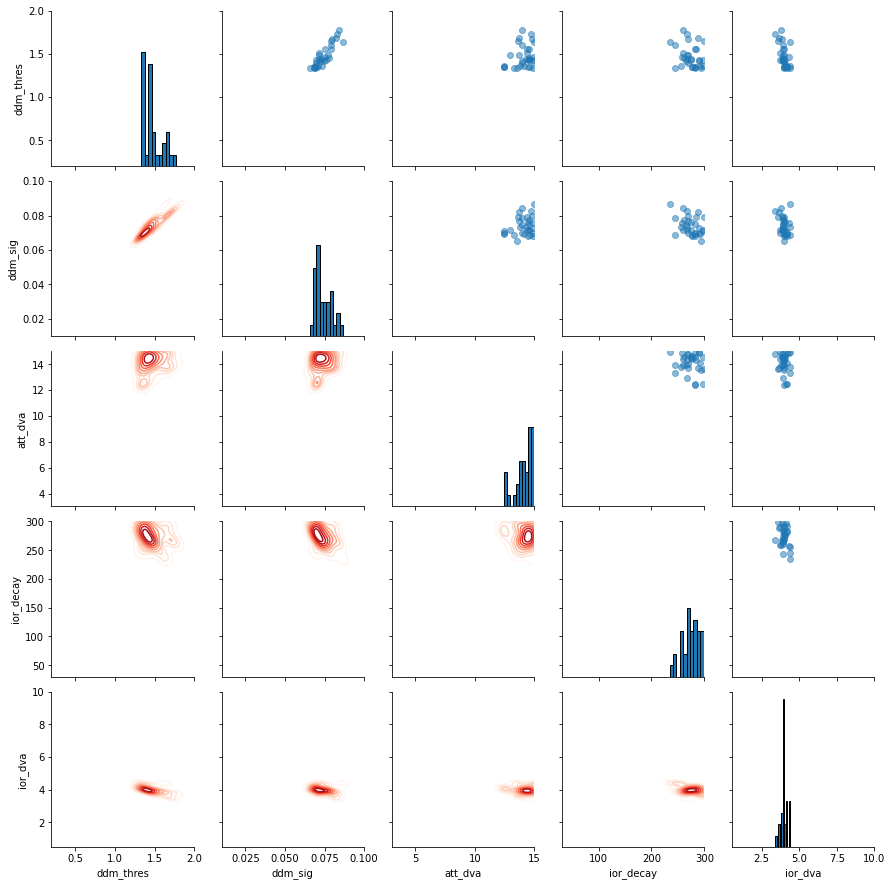

MainProcess root INFO     weightList not set, assuming single fitness value to be maximized.
MainProcess root INFO     Trajectory Name: results-2022-12-23-11H-45M-59S
MainProcess root INFO     Storing data to: ./data/hdf/evolution.hdf
MainProcess root INFO     Trajectory Name: results-2022-12-23-11H-45M-59S
MainProcess root INFO     Number of cores: 40
MainProcess pypet.storageservice.HDF5StorageService INFO     I will use the hdf5 file `./data/hdf/evolution.hdf`.
MainProcess pypet.environment.Environment INFO     Environment initialized.
MainProcess root INFO     Evolution: Using algorithm: adaptive
/home/users/n/nicolas-roth/miniconda3/envs/venv/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMulti' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/users/n/nicolas-roth/miniconda3/envs/venv/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A 

> Simulation parameters
HDF file storage: ./data/hdf/objDDM_train_molin_wFovCat_64-32-50_2022-12-15-17H-06M-23S_22029112.hdf
Trajectory Name: results-2022-12-15-17H-06M-23S
Duration of evaluating initial population 0:40:58.956235
Duration of evolution 17:10:19.086501
Eval function: <function optimize_me at 0x7f69c5dc0170>
Parameter space: {'ddm_thres': [1.0, 3.0], 'ddm_sig': [0.05, 0.25], 'att_dva': [5, 20], 'ior_decay': [30, 300], 'ior_inobj': [0.4, 1.0]}
> Evolution parameters
Number of generations: 50
Initial population size: 64
Population size: 32
> Evolutionary operators
Mating operator: <function cxBlend at 0x7f69d0c75320>
Mating paramter: {'alpha': 0.5}
Selection operator: <function selBest_multiObj at 0x7f69ccb50cb0>
Selection paramter: {}
Parent selection operator: <function selRank at 0x7f69ccb50c20>
Comments: no comments
--- Info summary ---
Valid: 32
Mean score (weighted fitness): -0.1
Parameter distribution (Generation 49):
ddm_thres: 	 mean: 1.8220,	 std: 0.0446
ddm_sig: 

/home/users/n/nicolas-roth/miniconda3/envs/venv/lib/python3.7/site-packages/neurolib/optimize/evolution/evolutionaryUtils.py:212: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


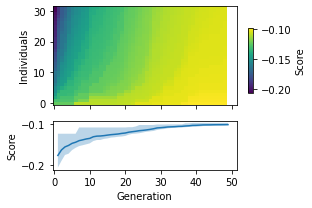

MainProcess root INFO     Saving plot to ./data/figures/results-2022-12-15-17H-06M-23S_hist_49.png


There are 32 valid individuals
Mean score across population: -0.1


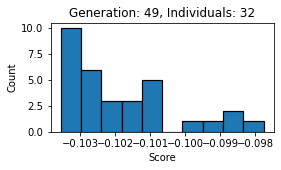

<Figure size 432x288 with 0 Axes>

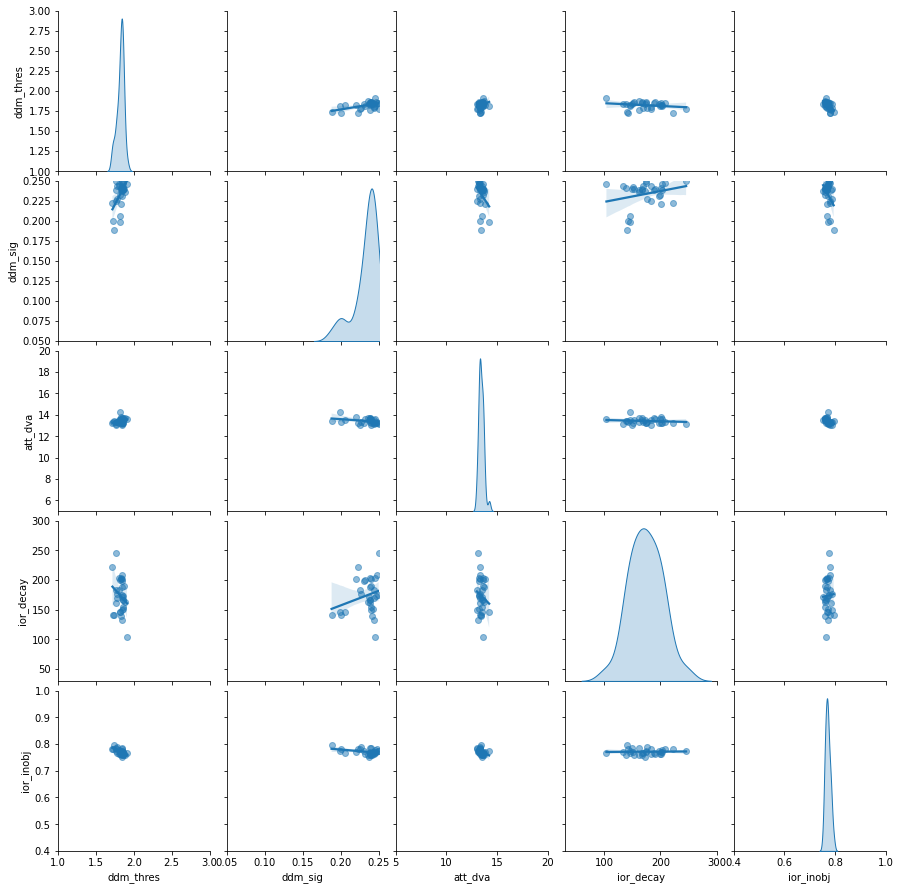

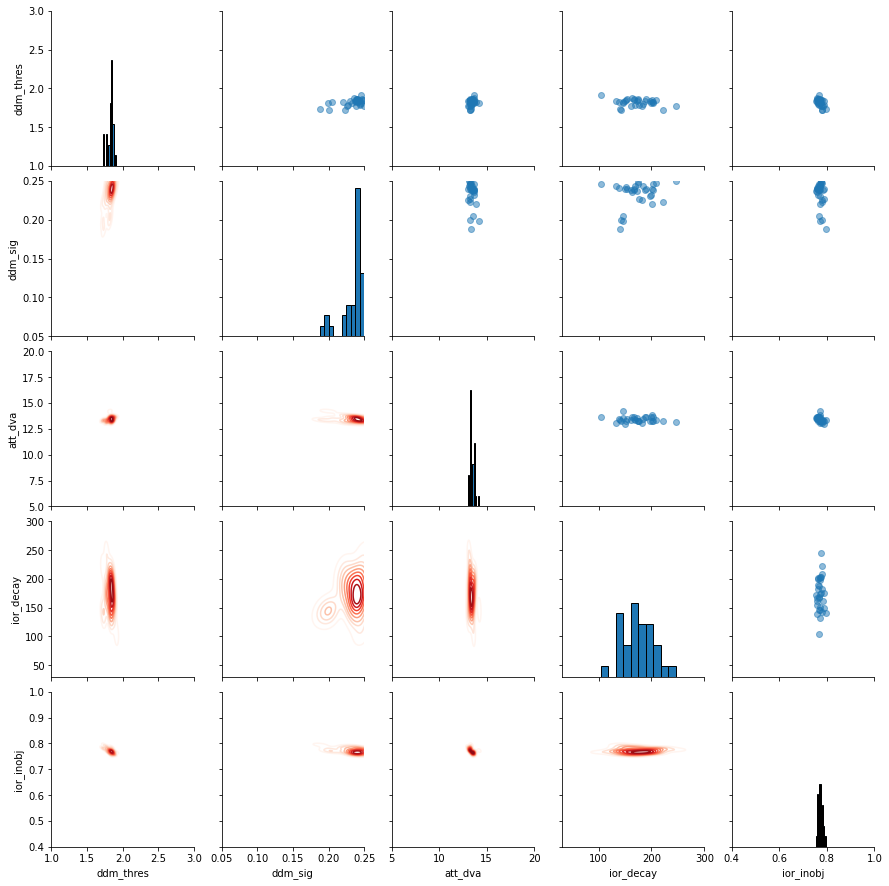

MainProcess root INFO     weightList not set, assuming single fitness value to be maximized.
MainProcess root INFO     Trajectory Name: results-2022-12-23-11H-46M-22S
MainProcess root INFO     Storing data to: ./data/hdf/evolution.hdf
MainProcess root INFO     Trajectory Name: results-2022-12-23-11H-46M-22S
MainProcess root INFO     Number of cores: 40
MainProcess pypet.storageservice.HDF5StorageService INFO     I will use the hdf5 file `./data/hdf/evolution.hdf`.
MainProcess pypet.environment.Environment INFO     Environment initialized.
MainProcess root INFO     Evolution: Using algorithm: adaptive
/home/users/n/nicolas-roth/miniconda3/envs/venv/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMulti' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/users/n/nicolas-roth/miniconda3/envs/venv/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A 

> Simulation parameters
HDF file storage: ./data/hdf/objDDM_train_None_wFovCat_64-32-50_2022-12-15-17H-05M-50S_22029111.hdf
Trajectory Name: results-2022-12-15-17H-05M-50S
Duration of evaluating initial population 0:45:05.482072
Duration of evolution 17:06:03.550046
Eval function: <function optimize_me at 0x7f69c8f1d950>
Parameter space: {'ddm_thres': [1.0, 3.0], 'ddm_sig': [0.05, 0.25], 'att_dva': [5, 20], 'ior_decay': [30, 300], 'ior_inobj': [0.4, 1.0]}
> Evolution parameters
Number of generations: 50
Initial population size: 64
Population size: 32
> Evolutionary operators
Mating operator: <function cxBlend at 0x7f69d0c75320>
Mating paramter: {'alpha': 0.5}
Selection operator: <function selBest_multiObj at 0x7f69ccb50cb0>
Selection paramter: {}
Parent selection operator: <function selRank at 0x7f69ccb50c20>
Comments: no comments
--- Info summary ---
Valid: 32
Mean score (weighted fitness): -0.18
Parameter distribution (Generation 49):
ddm_thres: 	 mean: 2.9412,	 std: 0.0538
ddm_sig: 

/home/users/n/nicolas-roth/miniconda3/envs/venv/lib/python3.7/site-packages/neurolib/optimize/evolution/evolutionaryUtils.py:212: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


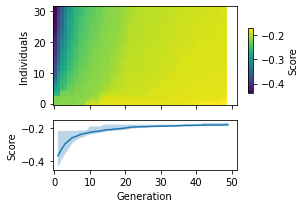

MainProcess root INFO     Saving plot to ./data/figures/results-2022-12-15-17H-05M-50S_hist_49.png


There are 32 valid individuals
Mean score across population: -0.18


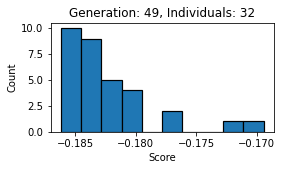

<Figure size 432x288 with 0 Axes>

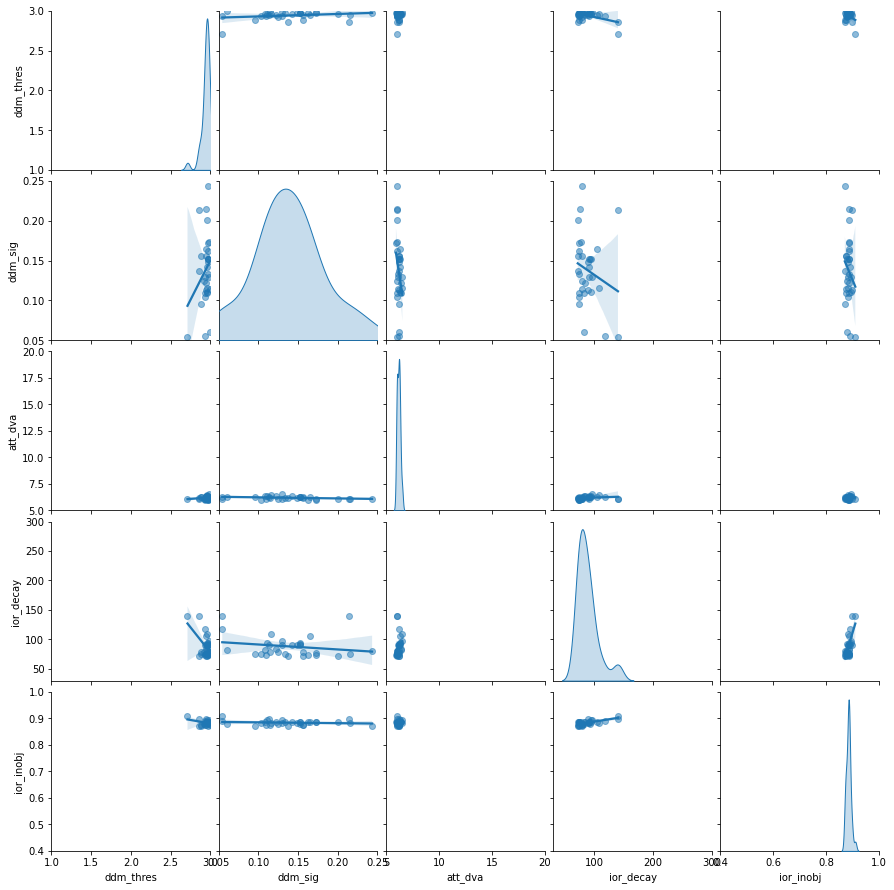

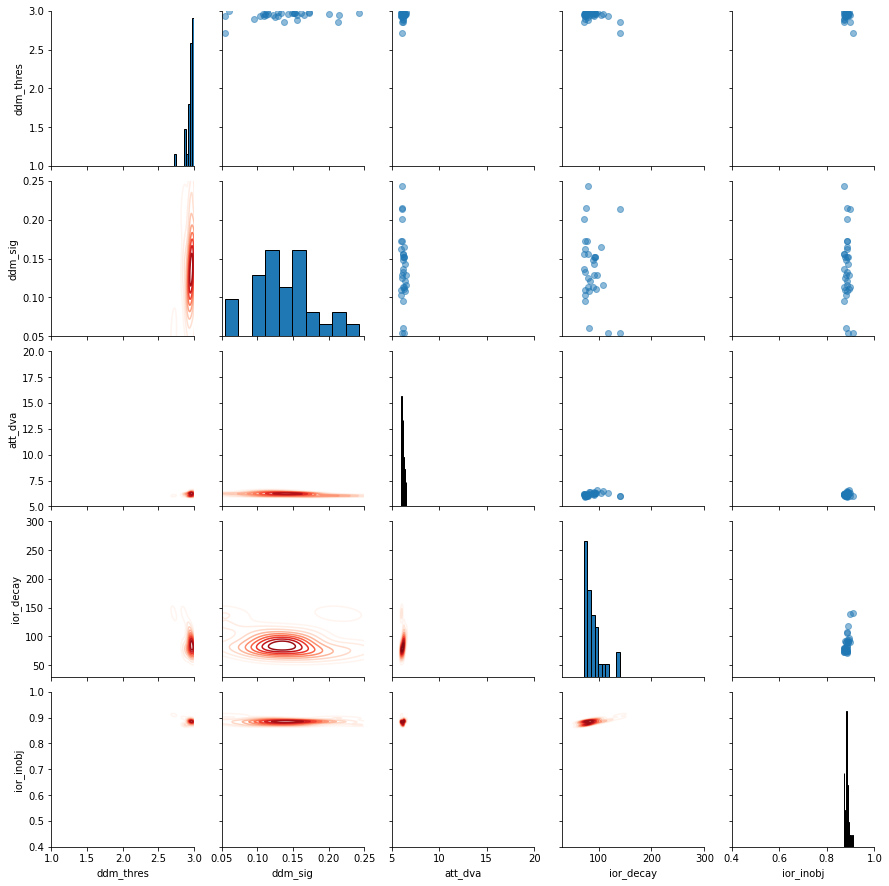

In [16]:
run_ids = [
    'pxDDM_train_molin_wFovCat_64-32-50_2022-12-15-17H-06M-38S_22029113',
    'pxDDM_train_TASEDnet_wFovCat_64-32-50_2022-12-15-17H-07M-00S_22029114',
    'objDDM_train_molin_wFovCat_64-32-50_2022-12-15-17H-06M-23S_22029112',
    'objDDM_train_None_wFovCat_64-32-50_2022-12-15-17H-05M-50S_22029111',
]
for runid in run_ids:
    DILLNAME = f'{runid}.dill'
    evol = Evolution(lambda x: x, ParameterSpace(['mock'], [[0, 1]]))
    evol = evol.loadEvolution(f'results/{runid}/{DILLNAME}')
    evol.info()


### quick comparison of train and test data

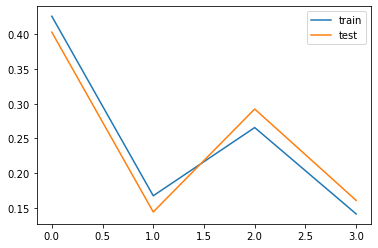

trainset:  [0.4259663789866386, 0.16730111098243414, 0.2655765640469341, 0.14115594598399314]
testset:  [0.4030932711138888, 0.143990883823684, 0.29228813057935943, 0.16062771448306778]


In [29]:
subjects_fovcat_train = list(VidCom.get_fovcat_ratio("train").values())
subjects_fovcat_test = list(VidCom.get_fovcat_ratio("test").values())
plt.plot(subjects_fovcat_train, label="train")
plt.plot(subjects_fovcat_test, label="test")
plt.legend(); plt.show()
print("trainset: ", subjects_fovcat_train)
print("testset: ", subjects_fovcat_test)

training
testing


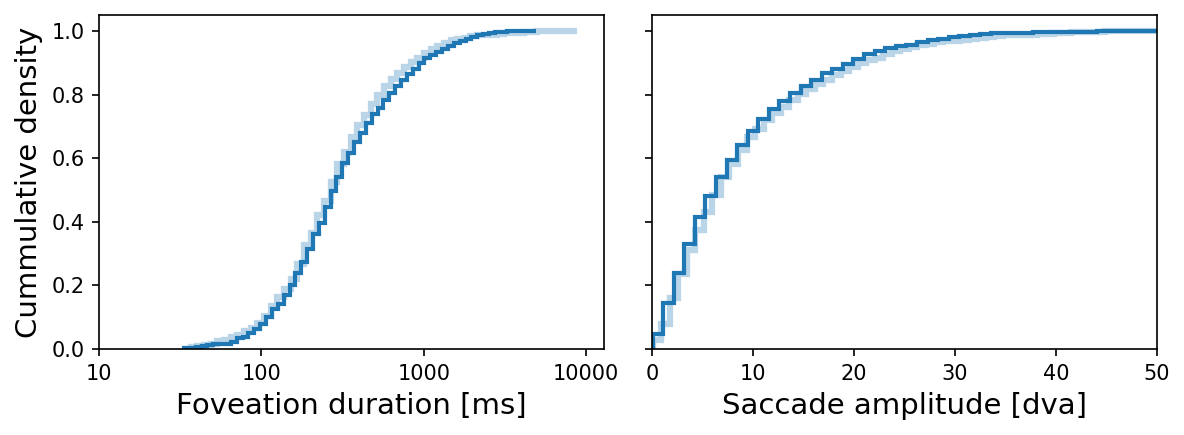

In [30]:
fig, axs = plt.subplots(1,2,dpi=150, figsize=(8,3), sharey=True)
cl = list(colors.TABLEAU_COLORS.values())
for modus in ["training", "testing"]:
    c_idx = 0
    print(modus)

    if modus == "training":
        videoset = VidCom.trainset
        gt_amp_dva = VidCom.train_foveation_df["sac_amp_dva"].dropna().values
        gt_dur_ms = VidCom.train_foveation_df["duration_ms"].dropna().values
        gtname = 'Human data (train)'
        kwargs = {"lw":3, "alpha":0.3} #"ls":"dotted", 
    else:
        videoset = VidCom.testset
        gt_amp_dva = VidCom.test_foveation_df["sac_amp_dva"].dropna().values
        gt_dur_ms = VidCom.test_foveation_df["duration_ms"].dropna().values
        kwargs = {"lw":2}#, "ls":"dotted", "alpha":0.5}

    
    gtname = 'Human data'# (test)'


    nbins = 60
    # sns.histplot(data=np.log10(gt_dur_ms), kde=False, ax=axs[0], cumulative=True, element='step')#, bins=20)
    axs[0].hist(np.log10(gt_dur_ms), nbins, density=True, histtype='step', cumulative=True, label=gtname, color=cl[0], **kwargs)
    axs[0].set_xticks([1,2,3,4])
    axs[0].set_xticklabels([10,100,1000,10000])
    axs[0].set_xlabel('Foveation duration [ms]', size=14)
    axs[0].set_ylabel('Cummulative density', size=14)
    #plt.legend()
    axs[1].hist(gt_amp_dva, nbins, density=True, histtype='step', cumulative=True, label=gtname, color=cl[0], **kwargs)
    axs[1].set_xlabel('Saccade amplitude [dva]', size=14)
    axs[1].set_xlim([0, 50])
    #fig.suptitle('Ground truth scanpath statistics (VidCom dataset)', size=18) #   
    # axs[1].legend(loc='lower right')
    uf.fix_hist_step_vertical_line_at_end(axs[0])
    uf.fix_hist_step_vertical_line_at_end(axs[1])
plt.tight_layout(); plt.show()


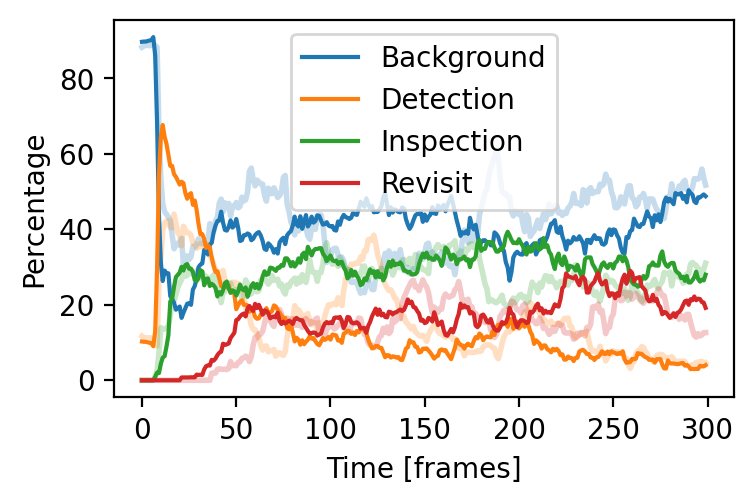

In [31]:
BDIR_per_frames_train = np.zeros((4,300))
BDIR_per_frames = np.zeros((4,300))
bdir_to_row = {'B': 0, 'D': 1, 'I': 2, 'R': 3}
for index, row in VidCom.train_foveation_df.iterrows():
    BDIR_per_frames_train[bdir_to_row[row['fov_category']], row['frame_start']:row['frame_end']+1] += 1
for index, row in VidCom.test_foveation_df.iterrows():
    BDIR_per_frames[bdir_to_row[row['fov_category']], row['frame_start']:row['frame_end']+1] += 1

combined_per_frames_train = np.sum(BDIR_per_frames_train, axis=0)
combined_per_frames = np.sum(BDIR_per_frames, axis=0)

fig, ax = plt.subplots(dpi=200, figsize=(4,2.5))
ax.plot(BDIR_per_frames_train[0] / combined_per_frames_train * 100, color=cl[0], lw=2, ls='-', alpha=0.25)
ax.plot(BDIR_per_frames_train[1] / combined_per_frames_train * 100, color=cl[1], lw=2, ls='-', alpha=0.25)
ax.plot(BDIR_per_frames_train[2] / combined_per_frames_train * 100, color=cl[2], lw=2, ls='-', alpha=0.25)
ax.plot(BDIR_per_frames_train[3] / combined_per_frames_train * 100, color=cl[3], lw=2, ls='-', alpha=0.25)
ax.plot(BDIR_per_frames[0] / combined_per_frames * 100, color=cl[0], label='Background')
ax.plot(BDIR_per_frames[1] / combined_per_frames * 100, color=cl[1], label='Detection')
ax.plot(BDIR_per_frames[2] / combined_per_frames * 100, color=cl[2], label='Inspection')
ax.plot(BDIR_per_frames[3] / combined_per_frames * 100, color=cl[3], label='Revisit')
ax.set(xlabel='Time [frames]', ylabel='Percentage') # title='Ground truth foveation category over time', 
plt.legend(); plt.show()
